In [1]:
## Import packages

import seaborn as sns
from seaborn import clustermap
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from scipy.stats import gaussian_kde
from sklearn import metrics
import networkx as nx
import pycirclize

In [2]:
################ Define functions here ################

##Import Max's handy upperTriangle function to avoid counting AB BA GIs twice
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(dropna=False).loc[keep]

## The function "deconstruct_tree"  will take an integer value representing the highest node of a hierarchical
## clustering and a distance matrix for that clustering. An empty list "branch_identity" must be defined first. 
def deconstruct_tree(start,tree):
    node = tree[start]
    if node[0] > len(tree):
        deconstruct_tree(int(node[0]-(len(tree)+1)),tree)
    if node[0] <= len(tree):
        branch_identity.append(node[0])
    if node[1] > len(tree):
        deconstruct_tree(int(node[1]-(len(tree)+1)),tree)
    if node[1] <= len(tree):
        branch_identity.append(node[1])


## Define a function that takes an Enrichr enrichment result and a significance threshold and returns a DataFrame 
## containing significant go-terms and their associated -log10 adjusted p-values over a certain threshold
def enrichDf(result,sig):
    result['Adjusted P-value'] = -np.log10(result['P-value'])
    termList =[]
    scoreList = []
    for go in result.loc[result['Adjusted P-value'] > sig]['Term']:
        goterm = go.split(' (')[0]
        termList.append(goterm)
    for score in result.loc[result['Adjusted P-value'] > sig]['Adjusted P-value']:
        scoreList.append(score)
    outDf = pd.DataFrame(index=termList)
    outDf['Score'] = scoreList
    return outDf

## Here I would like to iterate through every cluster and return a matrix with index equal to all the
## genes in the map, and columns equal to every cluster, with bools filled in to represent if that gene belongs to 
## that cluster
def make_cluster_matrix(gimap,distance_matrix):
    out_matrix = pd.DataFrame(index = gimap.index, columns = range(len(gimap.index)-1))
    for cluster in out_matrix.columns:
        branch_identity = []
        deconstruct_tree(cluster,distance_matrix)
        branch_names = gimap.iloc[branch_identity].index
        print(branch_identity)
        for gene in out_matrix.index:
            if gene in branch_names:
                out_matrix.loc[gene,cluster] = True
            else:
                out_matrix.loc[gene,cluster] = False
    return out_matrix

## Define a function, "rand_identifier" that will take a cluster in format [gene1,gene2,...,genex] and a gene index and
## return a list of size index with 0 or 1 denoting if the gene is in the cluster or not, for use with adjusted rand
def rand_identifier(cluster,index):
    out_list = []
    for item in index:
        if item in cluster:
            out_list.append(1)
        if item not in cluster:
            out_list.append(0)
    return out_list

## make_rand_df will make two cluster matrices, as defined below, and a refernce gene index and return a matrix that 
## contains all ARS scores between each pair of clusters in both matrices

def make_rand_df(cluster_matrix1, cluster_matrix2, ref_index):
    out_df = pd.DataFrame(index = cluster_matrix1.columns,columns = cluster_matrix2.columns)
    for i,row in enumerate(out_df.index):
        if i % 100 == 0:
            print(str(i)+' in progress!')
        list1 = list(cluster_matrix1.loc[cluster_matrix1[row]==True].index)
        rand1 = rand_identifier(list1,ref_index)
        for col in out_df.columns:
            list2 = list(cluster_matrix2.loc[cluster_matrix2[col]==True].index)
            rand2 = rand_identifier(list2,ref_index)
            out_df.loc[row,col] = metrics.adjusted_rand_score(rand1,rand2)
    return out_df
    

## A function that takes two lists and outputs 'True' if all elements in the first list exist in the second
def all_shared(list1,list2):
    for item in list1:
        if item not in list2:
            return False
            break
    return True


## annotate_tree will be used to fully annotate each map with clusters from a list of shared cluster between maps. It
## will take an empty input DataFrame with index equal to the unclustered GI map index, the GI map index itself, the 
## shared list, the GI cluster matrix, "layer" which should always be 0, "go_terms_analyzed", which should always be 
## an empty list and a dictionary where cluster identities are keys and values are color codes. Outputs a DataFrame 
## with index equal to the unclustered map index and columns equal to the number of layers of overlapping GO term
## annotated clusters. 

def annotation_tree(annotate_df, map_index, shared_list, cluster_matrix,layer,paired_dict):    
    layer = 0
    go_terms_analyzed = []
    total_gene_list = list(map_index)
    in_layer = pd.DataFrame(index = range(len(map_index)),columns =['fill'])
    in_layer = list(in_layer['fill'])
    for cluster in shared_list:
        if cluster in go_terms_analyzed:
            continue
        gene_list = list(cluster_matrix.loc[cluster_matrix[cluster]==True].index)
        if all_shared(gene_list,total_gene_list):
            for i,gene in enumerate(annotate_df.index):
                if gene in gene_list:
                    if cluster in paired_dict.keys():
                        in_layer[i] = paired_dict[cluster]
                        #in_layer[i] = 'lightcoral'
                    else:
                        in_layer[i] = 'black'
            total_gene_list = [item for item in total_gene_list if item not in gene_list]
            go_terms_analyzed.append(cluster)
    annotate_df[layer] = in_layer
    layer += 1 
    if all_shared(list(shared_list),go_terms_analyzed) == False:
        annotation_tree(annotate_df,map_index,shared_list,cluster_matrix,layer,go_terms_analyzed,paired_dict)
    return annotate_df

## Define a function, "rand_identifier" that will take a cluster in format [gene1,gene2,...,genex] and an index and
## return a list of size index with 0 or 1 denoting if the gene is in the cluster or not, for use with adjusted rand
def rand_identifier(cluster,index):
    out_list = []
    for item in index:
        if item in cluster:
            out_list.append(1)
        if item not in cluster:
            out_list.append(0)
    return out_list

## cummulative_rand takes a rand matrix for a given clustering comparison and returns the average maximum rand score
## found for each cluster in the rand matrix index. A rough indication of the similarity of two distinct hierarchical
## clusterings
def cummulative_rand(rand_matrix):
    out = 0
    for cluster in rand_matrix.index:
        out += rand_matrix.loc[cluster,:].max() 
    return out/len(rand_matrix.index)
 
## cluster_thresh will take a distance matrix a distance threshold and return a list of the largest clusters that are
## generated under that threshold. Output will list clusters drawn as max_number_elements+cluster_number, in this case
## max_number_elements is 302
def cluster_thresh(distance_matrix,distance_thresh):
    out_list = []
    for i,branch in enumerate(distance_matrix):
        if branch[2] > distance_thresh:
            break 
        if branch[0] in out_list:
            out_list.remove(branch[0])
        if branch[1] in out_list:
            out_list.remove(branch[1])
        out_list.append(i+303)
    return out_list
    
## make_ont_map takes a list of ontology name "o_list", a list of cluster identities associated with those ontologies
## "o_cluster_list", a matrix of GI scores "gi_map", and a cluster matrix for the hierarchical clustering and returns
## a matrix of the absolute average GI scores between all genes in each pair of ontologies within the map
def make_ont_map(o_list,o_cluster_list,gi_map,cluster_matrix):
    out_map = pd.DataFrame(index = o_list, columns = o_list)
    for i in range(len(out_map.index)):
        gl1 = list(consensus_cluster_matrix.loc[cluster_matrix[o_cluster_list[i]]==True].index)
        for j in range(len(out_map.columns)):
            gl2 = list(consensus_cluster_matrix.loc[cluster_matrix[o_cluster_list[j]]==True].index)
            out_map.iloc[i,j] = float(gi_map.loc[gl1,gl2].values.mean())
    return out_map
    
## make_nx_graph takes an ont_map as returned by the function "make_ont_map"
def make_nx_graph(ont_map,adjust,thresh):
    out_graph = nx.Graph()
    for ont1 in ont_map.index:
        for ont2 in ont_map.columns:
            if ont1 == ont2:
                continue
            if ont1 not in out_graph.nodes:
                out_graph.add_node(ont1,color='dimgray')
            if ont2 not in out_graph.nodes:
                out_graph.add_node(ont2,color='dimgray') 
            if abs(ont_map.loc[ont1,ont2]) > thresh:
                out_graph.add_node(ont1,color = ont_color_key[ont1])
                out_graph.add_node(ont2,color = ont_color_key[ont2])
                out_graph.add_edge(ont1,ont2,weight = (abs(ont_map.loc[ont1,ont2]**2)/adjust),color='lightcoral')    
            if abs(ont_map.loc[ont1,ont2]) < thresh:
                out_graph.add_edge(ont1,ont2,weight = (abs(ont_map.loc[ont1,ont2])/adjust),color='dimgray')
    plt.figure(figsize=(5,5))   
    plt.axis('off')
    nx.draw_networkx(out_graph,
        pos = nx.circular_layout(out_graph),
        node_color = [item[1] for item in out_graph.nodes.data('color')],
        edge_color = [item[2] for item in out_graph.edges.data('color')],
        node_size = 200,
        width = [item[2] for item in out_graph.edges.data('weight')],
        with_labels = False
                )

    
    
## make_col_df will take a gene list that is the index of a GI map, and, given a "consensus_annotations" DF, and a 
## "ont_color_key" dictionary, will return a df of index equal to the gene list and a color "Color" with the associated
## color relating to a GO term enriched cluster present in the data
def make_col_df(gene_list):
    out_df = pd.DataFrame(index = gene_list,columns = ['Color'])
    for gene in gene_list:
        for i in consensus_annotations.index:
            if gene in consensus_annotations.loc[i,'Genes']:
                term = consensus_annotations.loc[i,"Term"]
                if term != 'none':
                    out_df.loc[gene,'Color'] = ont_color_key[term]
    out_df = out_df.fillna('dimgray')   
    return out_df

def make_ont_col_df(gene_list,target_list):
    out_df = pd.DataFrame(index = gene_list,columns = ['Color'])
    for gene in gene_list:
        for i in consensus_annotations.index:
            if gene in consensus_annotations.loc[i,'Genes']:
                term = consensus_annotations.loc[i,"Term"]
                if term in target_list:
                    out_df.loc[gene,'Color'] = ont_color_key[term]           
    out_df = out_df.fillna('dimgray')   
    return out_df

def make_gene_col_df(gene_list,target_list):
    #c_temp = sns.color_palette("husl",len(target_list))
    out_df = pd.DataFrame(index = gene_list, columns = ['Color'])
    for i, gene in enumerate(target_list):
        out_df.loc[gene,'Color'] = 'lightcoral'
    out_df = out_df.fillna('dimgray')    
    return out_df


In [9]:
## A color map from Max Horlbeck in his 14.33 notebook for drawing GI heatmaps in the traditional blue/yellow scheme

cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad('w')

plt.register_cmap(cmap=blue_yellow)

In [3]:
## Import data

dmso1_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso1_map.xlsx',index_col = 0)
atr_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/atr_map.xlsx',index_col = 0)
dmso2_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/dmso2_map.xlsx',index_col = 0)
etop_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/etop_map.xlsx',index_col = 0)
keto_map = pd.read_excel('/Users/benh/Desktop/GI_data/gene_maps/keto_map.xlsx',index_col = 0)

dmso1_map = dmso1_map.fillna(0)
atr_map = atr_map.fillna(0)
dmso2_map = dmso2_map.fillna(0)
etop_map = etop_map.fillna(0)
keto_map = keto_map.fillna(0)

In [4]:
## Remove 'non-targeting' from GI matrices

dmso1_map = dmso1_map.loc[dmso1_map.index != 'non-targeting',dmso1_map.index != 'non-targeting']
atr_map = atr_map.loc[atr_map.index != 'non-targeting',atr_map.index != 'non-targeting']
dmso2_map = dmso2_map.loc[dmso2_map.index != 'non-targeting',dmso2_map.index != 'non-targeting']
etop_map = etop_map.loc[etop_map.index != 'non-targeting',etop_map.index != 'non-targeting']
keto_map = keto_map.loc[keto_map.index != 'non-targeting',keto_map.index != 'non-targeting']

In [5]:
## Make difference maps

dmso_di_map = dmso1_map - dmso2_map
etop_di_map = etop_map - dmso2_map
keto_di_map = keto_map - dmso2_map
atr_di_map = atr_map - dmso1_map


## A color map for the difference map specifically
diffColors = sns.diverging_palette(139,288,s= 63, l=64, center="dark", as_cmap=True)


In [6]:
## Make a consensus map by first normalizing all individual maps, then concatenating along one axis

dmso1_norm = dmso1_map/upperTriangle(dmso1_map).values.std()
atr_norm = atr_map/upperTriangle(atr_map).values.std()
dmso2_norm = dmso2_map/upperTriangle(dmso2_map).values.std()
etop_norm = etop_map/upperTriangle(etop_map).values.std()
keto_norm = keto_map/upperTriangle(keto_map).values.std()

concat_map = pd.concat((dmso2_norm,etop_norm,keto_norm,dmso1_norm,atr_norm),axis=1)

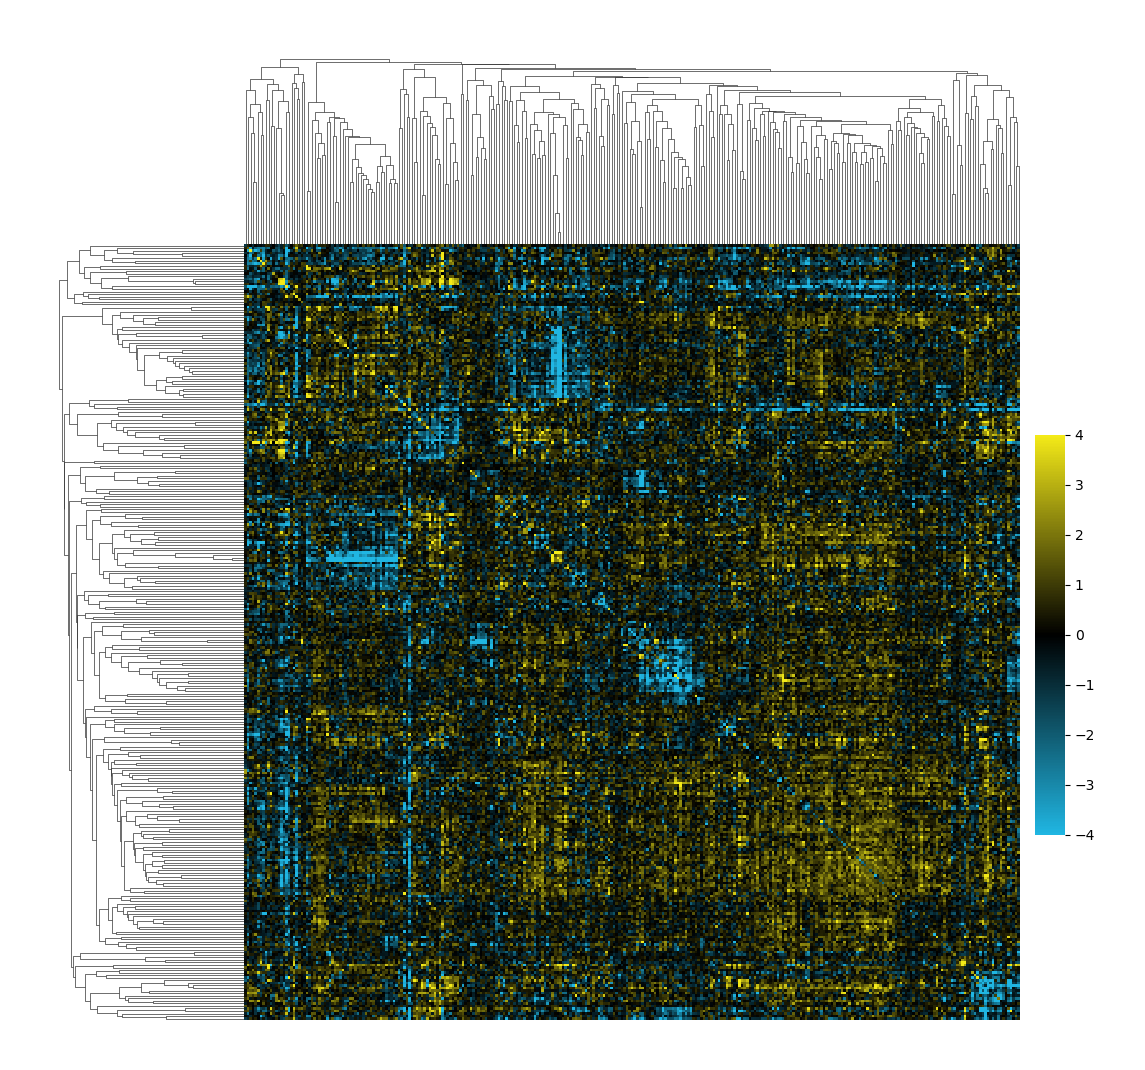

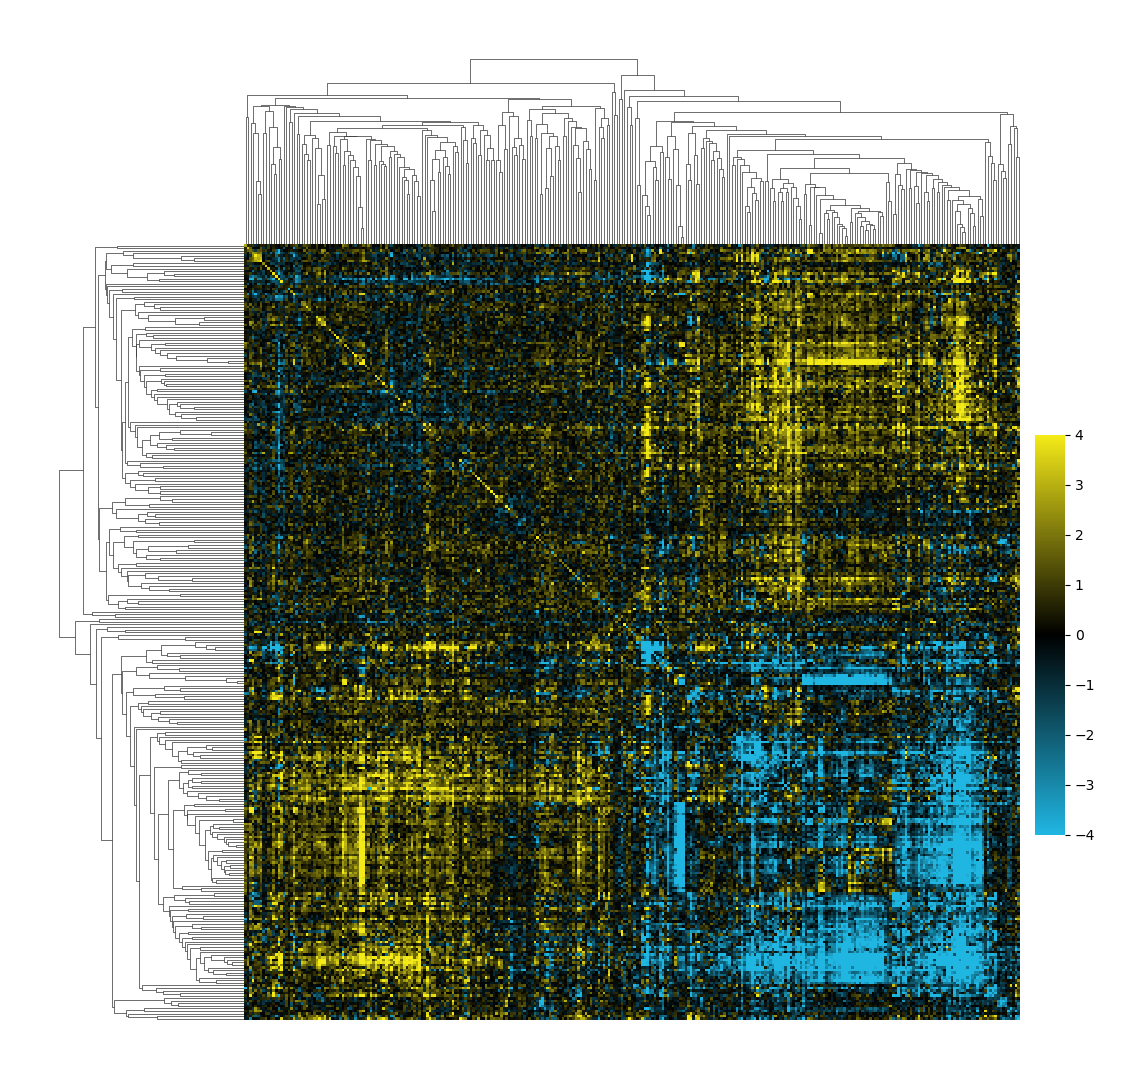

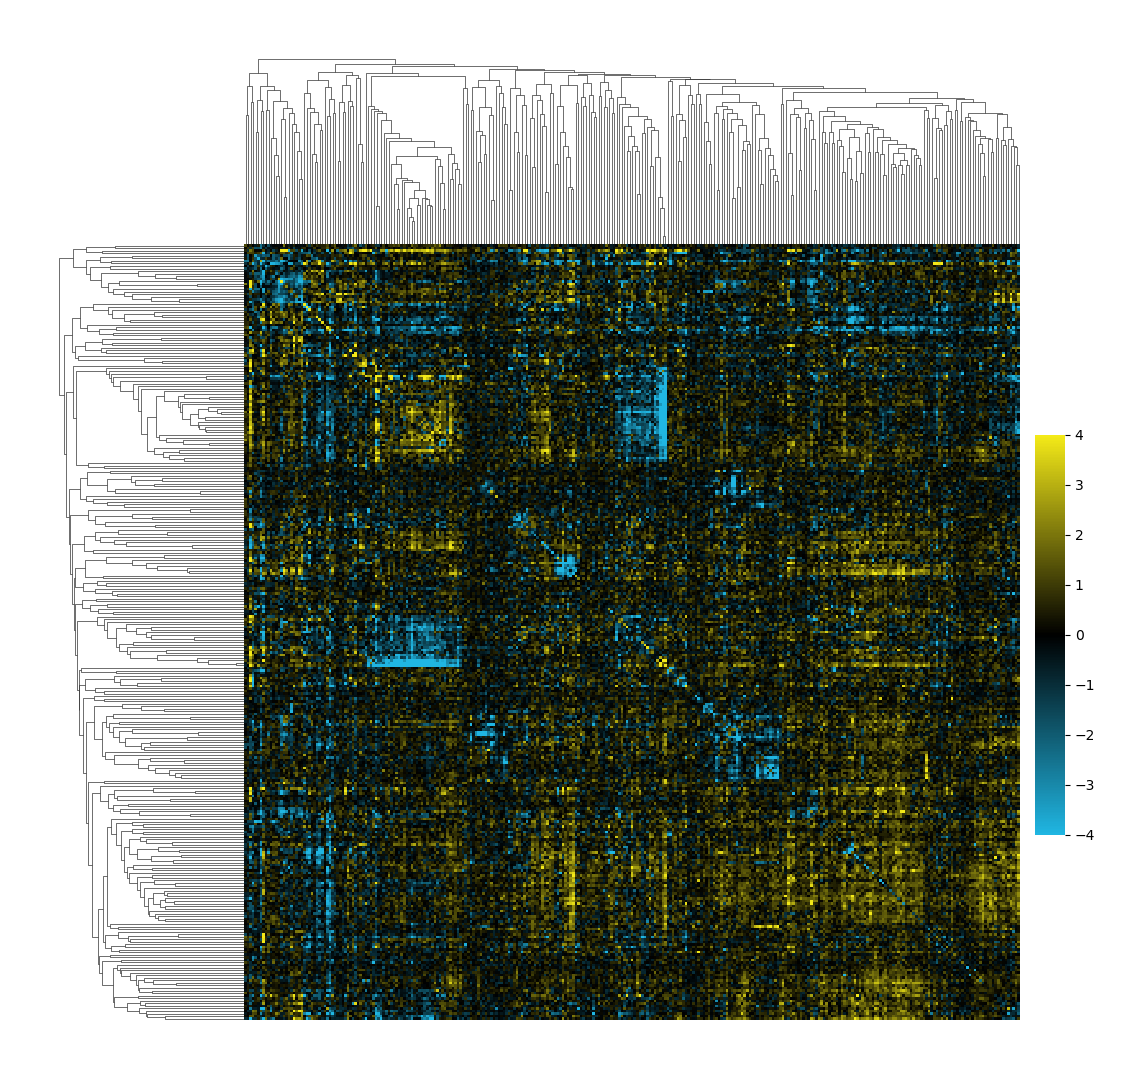

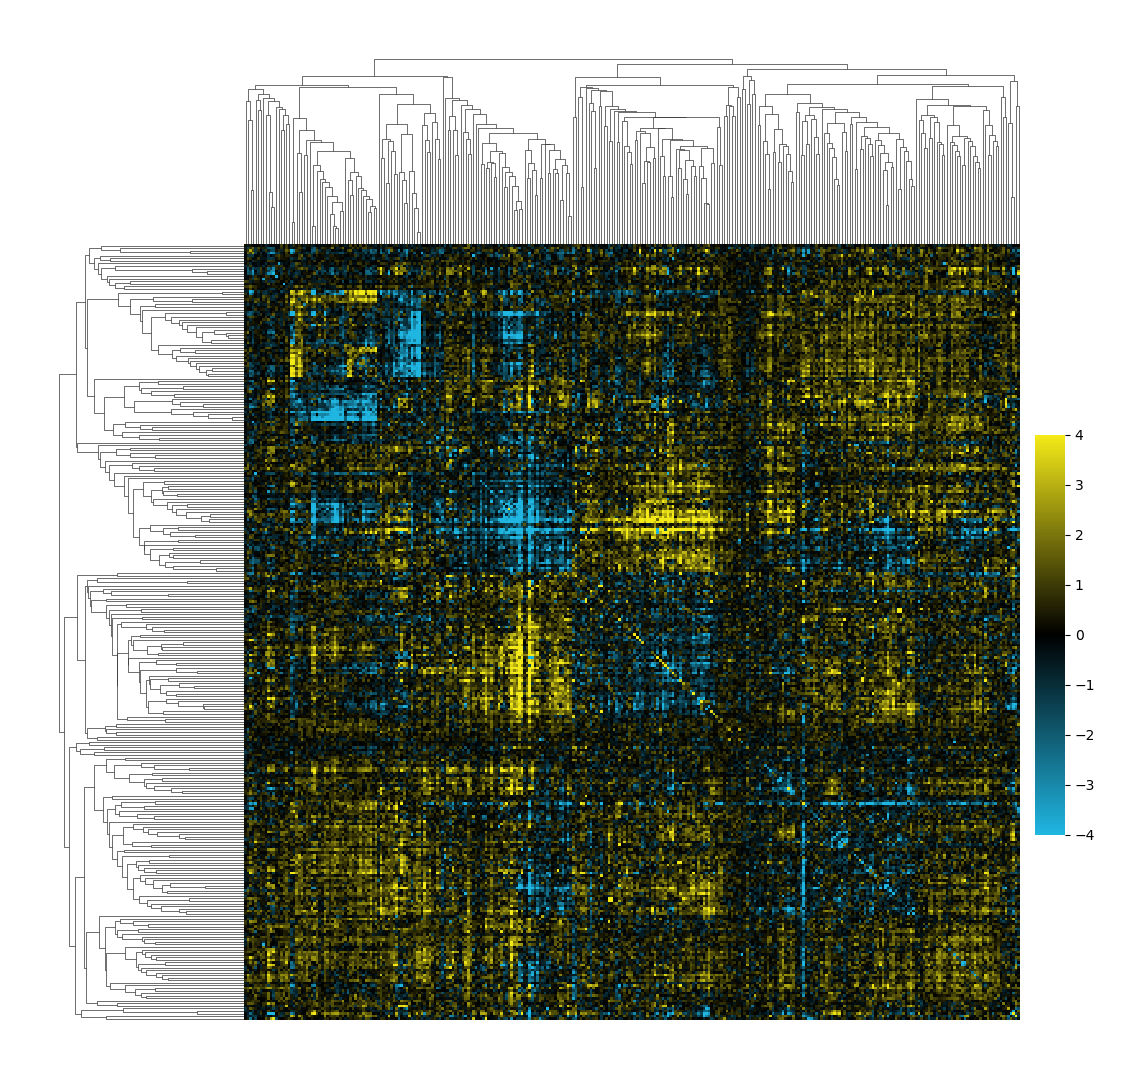

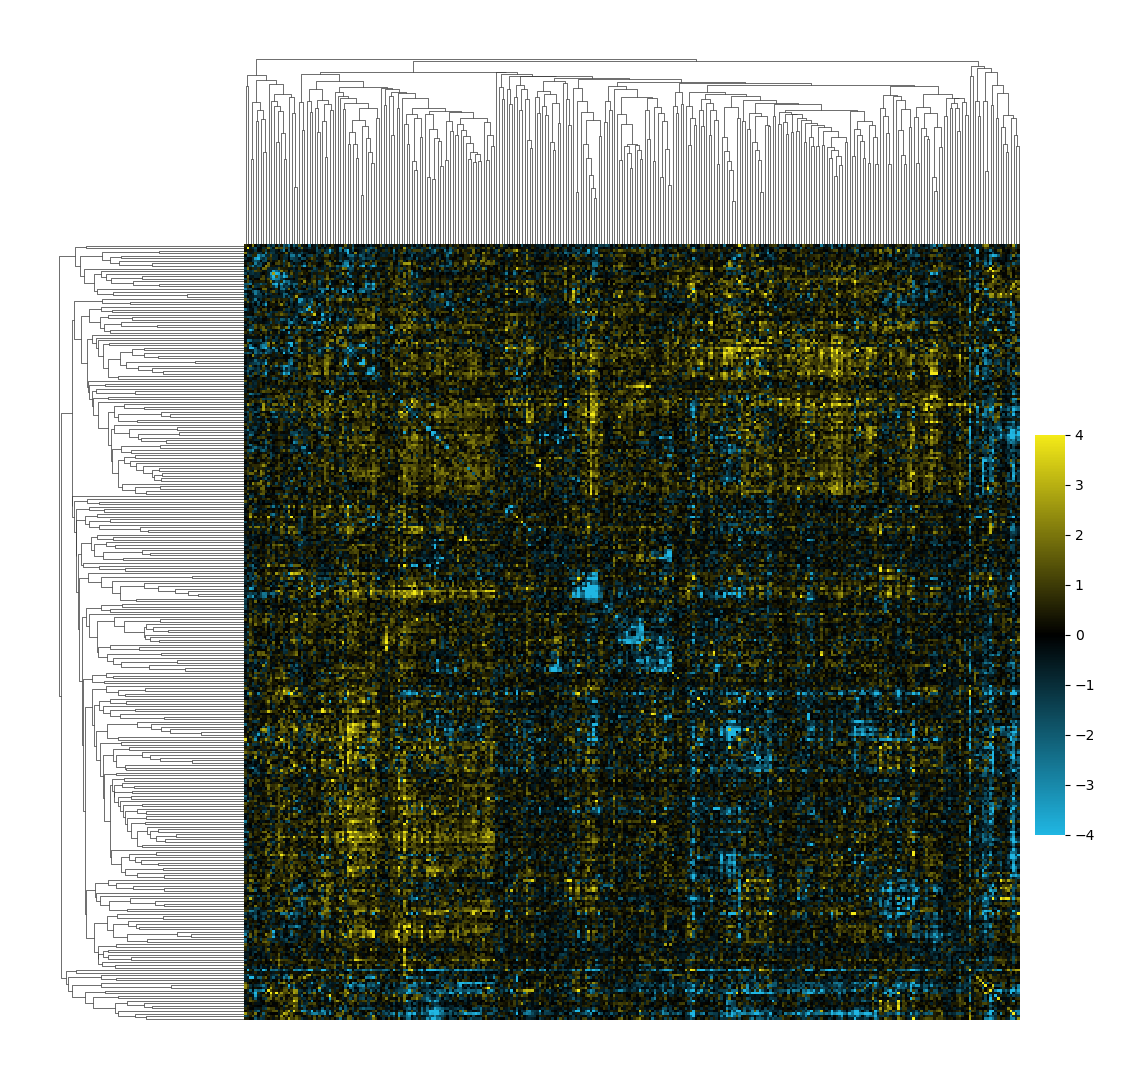

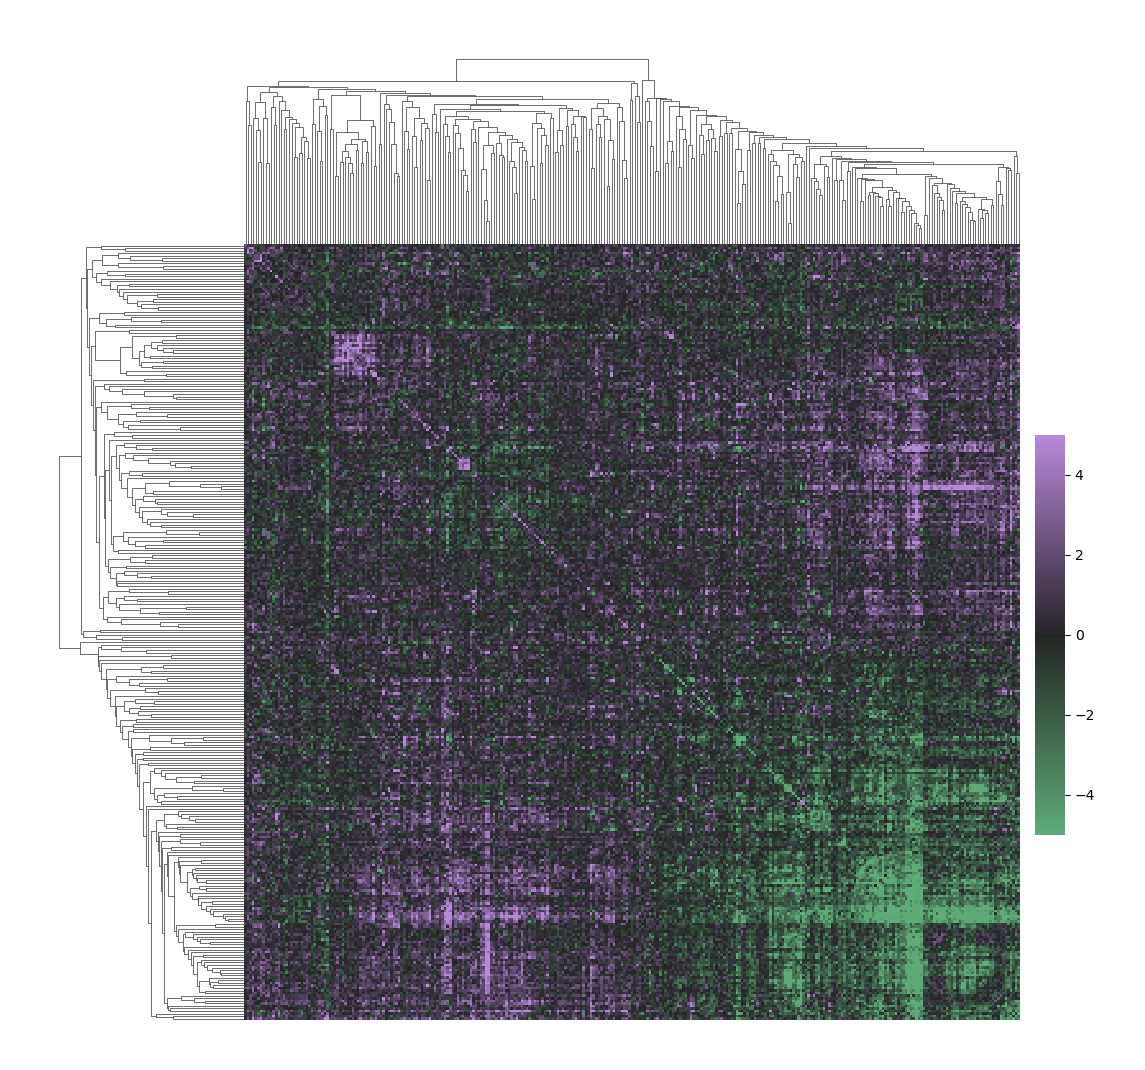

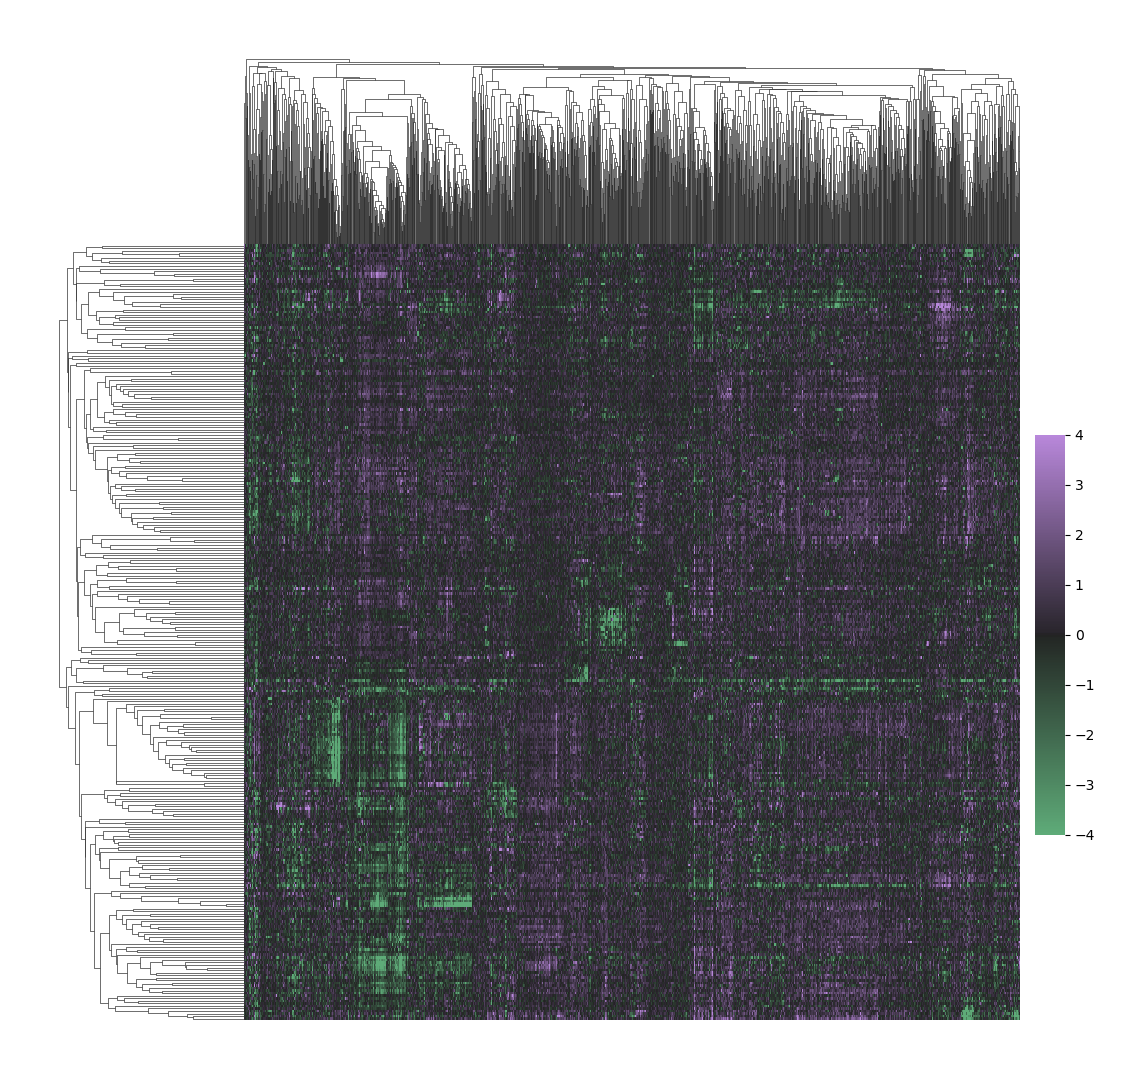

In [10]:
## Generate all clusterings

dmso1_cluster = sns.clustermap(dmso1_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )

atr_cluster = sns.clustermap(atr_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
dmso2_cluster = sns.clustermap(dmso2_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
etop_cluster = sns.clustermap(etop_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
keto_cluster = sns.clustermap(keto_map,method = 'average',metric = 'correlation',
                             cmap = blue_yellow,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )
atr_di_cluster = sns.clustermap(atr_di_map,method = 'average',metric = 'correlation',
                             cmap = diffColors,
                             vmin=-5,vmax = 5,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )

concat_cluster = sns.clustermap(concat_map,method = 'average',metric = 'correlation',
                             cmap = diffColors,
                             vmin=-4,vmax = 4,
                             cbar_pos=(1, .2, .03, .4),
                             yticklabels=False,xticklabels=False,
                            )

In [11]:
dmso1_clustered = dmso1_map.iloc[dmso1_cluster.dendrogram_row.reordered_ind,dmso1_cluster.dendrogram_row.reordered_ind]
atr_clustered = atr_map.iloc[atr_cluster.dendrogram_row.reordered_ind,atr_cluster.dendrogram_row.reordered_ind]
dmso2_clustered = dmso2_map.iloc[dmso2_cluster.dendrogram_row.reordered_ind,dmso2_cluster.dendrogram_row.reordered_ind]
etop_clustered = etop_map.iloc[etop_cluster.dendrogram_row.reordered_ind,etop_cluster.dendrogram_row.reordered_ind]
keto_clustered = keto_map.iloc[keto_cluster.dendrogram_row.reordered_ind,keto_cluster.dendrogram_row.reordered_ind]

atr_di_clustered = atr_di_map.iloc[atr_di_cluster.dendrogram_row.reordered_ind,atr_di_cluster.dendrogram_row.reordered_ind]

dmso1_distance = sp.cluster.hierarchy.linkage(dmso1_map, method='average', metric='correlation')
atr_distance = sp.cluster.hierarchy.linkage(atr_map, method='average', metric='correlation')
dmso2_distance = sp.cluster.hierarchy.linkage(dmso2_map, method='average', metric='correlation')
etop_distance = sp.cluster.hierarchy.linkage(etop_map, method='average', metric='correlation')
keto_distance = sp.cluster.hierarchy.linkage(keto_map, method='average', metric='correlation')

consensus_distance = sp.cluster.hierarchy.linkage(concat_map, method='average', metric='correlation')



In [12]:
dmso1_cluster_matrix = pd.DataFrame(index = dmso1_clustered.index, columns = range(302))

for cluster in dmso1_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,dmso1_distance)
    branch_names = dmso1_map.iloc[branch_identity].index
    for gene in dmso1_cluster_matrix.index:
        if gene in branch_names:
            dmso1_cluster_matrix.loc[gene,cluster] = True
        else:
            dmso1_cluster_matrix.loc[gene,cluster] = False
            

In [13]:
atr_cluster_matrix = pd.DataFrame(index = atr_clustered.index, columns = range(302))

for cluster in atr_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,atr_distance)
    branch_names = atr_map.iloc[branch_identity].index
    for gene in atr_cluster_matrix.index:
        if gene in branch_names:
            atr_cluster_matrix.loc[gene,cluster] = True
        else:
            atr_cluster_matrix.loc[gene,cluster] = False

In [14]:
dmso2_cluster_matrix = pd.DataFrame(index = dmso2_clustered.index, columns = range(302))

for cluster in dmso2_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,dmso2_distance)
    branch_names = dmso2_map.iloc[branch_identity].index
    for gene in dmso2_cluster_matrix.index:
        if gene in branch_names:
            dmso2_cluster_matrix.loc[gene,cluster] = True
        else:
            dmso2_cluster_matrix.loc[gene,cluster] = False

In [15]:
etop_cluster_matrix = pd.DataFrame(index = etop_clustered.index, columns = range(302))

for cluster in etop_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,etop_distance)
    branch_names = etop_map.iloc[branch_identity].index
    for gene in etop_cluster_matrix.index:
        if gene in branch_names:
            etop_cluster_matrix.loc[gene,cluster] = True
        else:
            etop_cluster_matrix.loc[gene,cluster] = False

In [16]:
keto_cluster_matrix = pd.DataFrame(index = keto_clustered.index, columns = range(302))

for cluster in keto_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,keto_distance)
    branch_names = keto_map.iloc[branch_identity].index
    for gene in keto_cluster_matrix.index:
        if gene in branch_names:
            keto_cluster_matrix.loc[gene,cluster] = True
        else:
            keto_cluster_matrix.loc[gene,cluster] = False

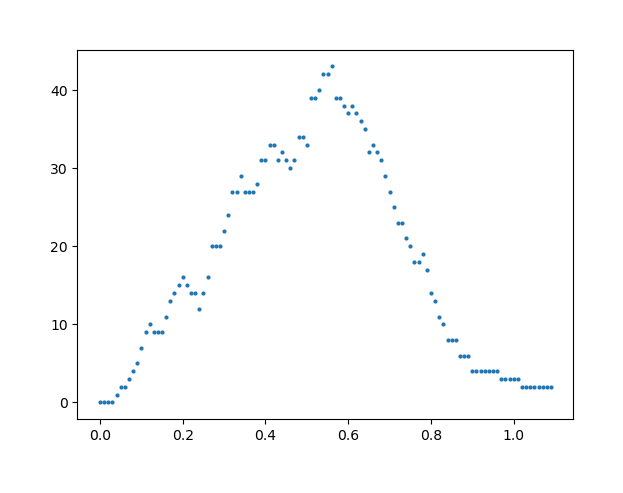

In [17]:
out_list = []
for i in np.arange(0,1.1,0.01):
    out_list.append(len(cluster_thresh(atr_distance,i)))

plt.scatter(np.arange(0,1.1,0.01),out_list)

In [18]:
## make a upper triangle mask to apply to each map

dmso2_mask = pd.DataFrame(index = dmso2_clustered.index,columns = dmso2_clustered.columns)

for i in range(len(dmso2_mask.index)):
    for j in range(i,len(dmso2_mask.columns)):
        if i != j:
            dmso2_mask.iloc[j,i] = True
dmso2_mask = dmso2_mask.fillna(False)

etop_mask = pd.DataFrame(index = etop_clustered.index,columns = etop_clustered.columns)

for i in range(len(etop_mask.index)):
    for j in range(i,len(etop_mask.columns)):
        if i != j:
            etop_mask.iloc[j,i] = True
etop_mask = etop_mask.fillna(False)

keto_mask = pd.DataFrame(index = keto_clustered.index,columns = keto_clustered.columns)

for i in range(len(keto_mask.index)):
    for j in range(i,len(keto_mask.columns)):
        if i != j:
            keto_mask.iloc[j,i] = True
keto_mask = keto_mask.fillna(False)

dmso1_mask = pd.DataFrame(index = dmso1_clustered.index,columns = dmso1_clustered.columns)

for i in range(len(dmso1_mask.index)):
    for j in range(i,len(dmso1_mask.columns)):
        if i != j:
            dmso1_mask.iloc[j,i] = True
dmso1_mask = dmso1_mask.fillna(False)

atr_mask = pd.DataFrame(index = atr_clustered.index,columns = atr_clustered.columns)

for i in range(len(atr_mask.index)):
    for j in range(i,len(atr_mask.columns)):
        if i != j:
            atr_mask.iloc[j,i] = True
atr_mask = atr_mask.fillna(False)

atr_di_mask = pd.DataFrame(index = atr_di_clustered.index,columns = atr_di_clustered.columns)

for i in range(len(atr_di_mask.index)):
    for j in range(i,len(atr_di_mask.columns)):
        if i != j:
            atr_di_mask.iloc[j,i] = True
atr_di_mask = atr_di_mask.fillna(False)

In [19]:
low = 0.55
high = 0.8

In [20]:
dmso2_low_clusters = cluster_thresh(dmso2_distance,low)
dmso2_high_clusters = cluster_thresh(dmso2_distance,high)
dmso2_cluster_color = pd.DataFrame(index = dmso2_map.index,columns=['high','low'])

for item in dmso2_high_clusters:
    gl = dmso2_cluster_matrix.loc[dmso2_cluster_matrix[item-303]].index
    for gene in gl:
        dmso2_cluster_color.loc[gene,'high'] = 'firebrick'
for item in dmso2_low_clusters:
    gl = dmso2_cluster_matrix.loc[dmso2_cluster_matrix[item-303]].index
    for gene in gl:
        dmso2_cluster_color.loc[gene,'low'] = 'lightcoral'
        
dmso2_cluster_color = dmso2_cluster_color.fillna('black')

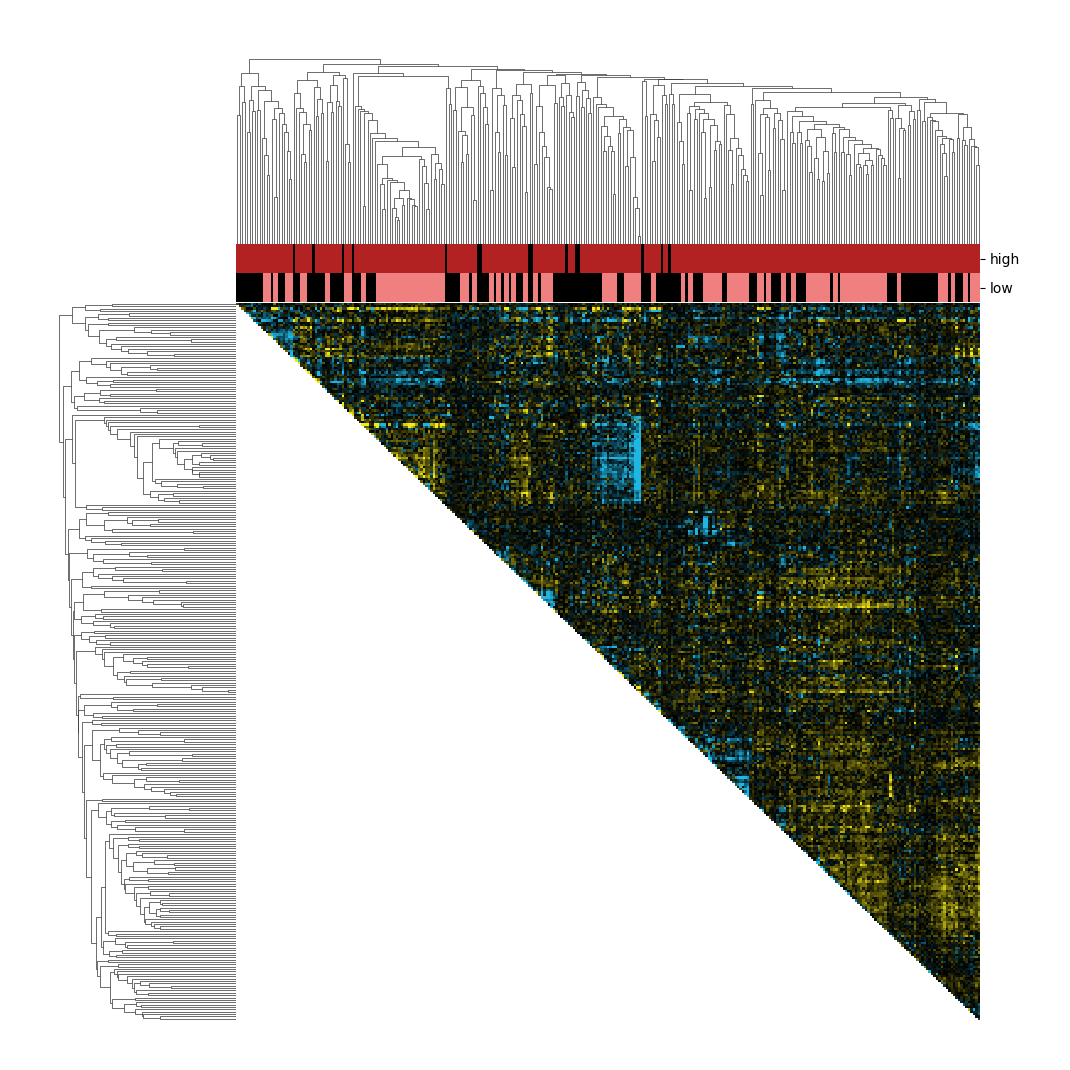

In [21]:
clustermap(dmso2_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos= None,#(1, .2, .03, .4),
           yticklabels=False,xticklabels=False,
           col_colors = dmso2_cluster_color,
           #colors_ratio = (0,0.010),
           #dendrogram_ratio= (0.10,0),
           figsize=(10,10),
           mask = dmso2_mask
          )

#plt.savefig('/Users/benh/Desktop/for_figs/dmso2_clustermap.png',dpi = 300)

In [22]:
etop_low_clusters = cluster_thresh(etop_distance,low)
etop_high_clusters = cluster_thresh(etop_distance,high)
etop_cluster_color = pd.DataFrame(index = etop_map.index,columns=['high','low'])

for item in etop_high_clusters:
    gl = etop_cluster_matrix.loc[etop_cluster_matrix[item-303]].index
    for gene in gl:
        etop_cluster_color.loc[gene,'high'] = 'orange'
for item in etop_low_clusters:
    gl = etop_cluster_matrix.loc[etop_cluster_matrix[item-303]].index
    for gene in gl:
        etop_cluster_color.loc[gene,'low'] = 'moccasin'
        
etop_cluster_color = etop_cluster_color.fillna('black')

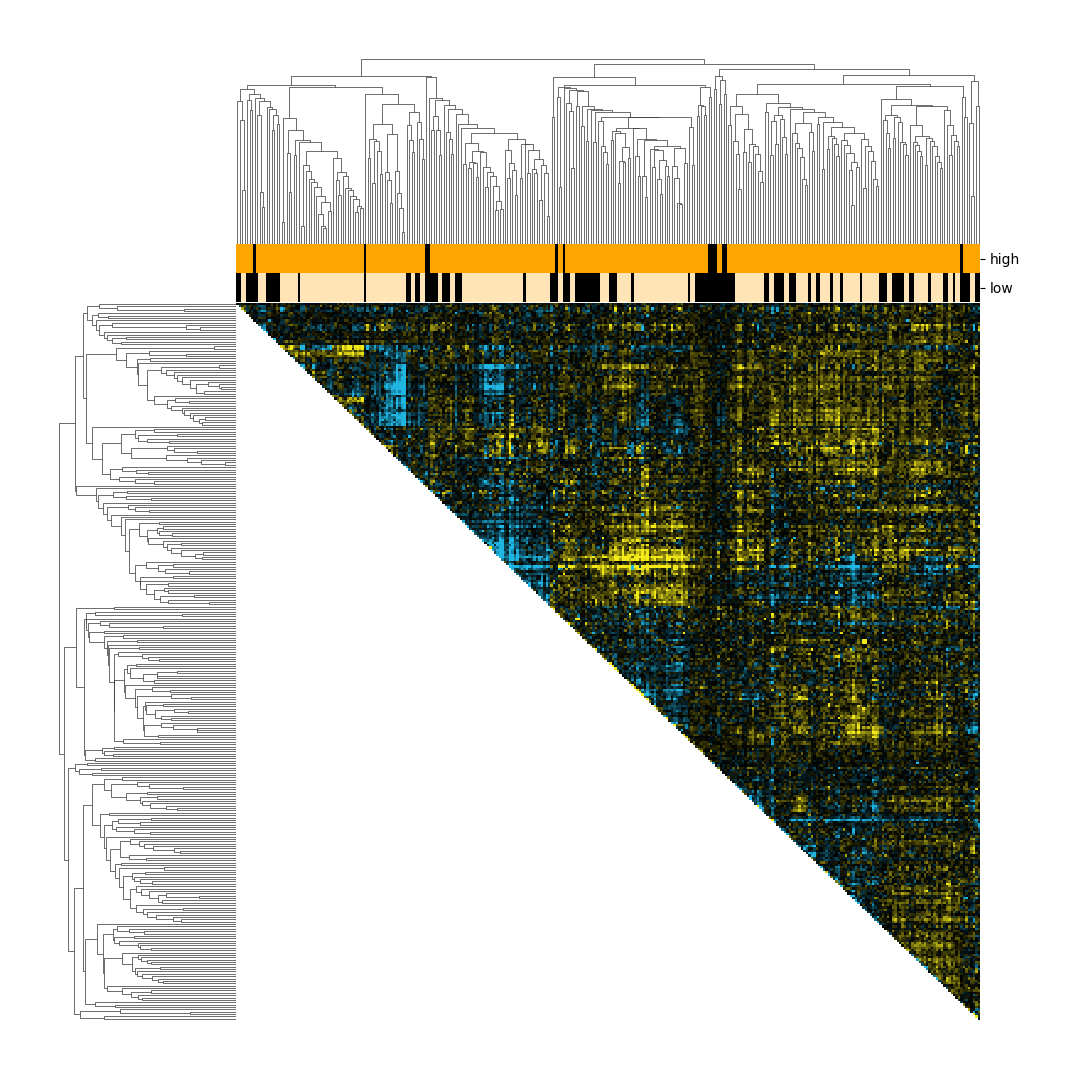

In [23]:
clustermap(etop_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos= None,
           yticklabels=False,xticklabels=False,
           col_colors = etop_cluster_color,
           #dendrogram_ratio= (0,0.15),
           figsize=(10,10),
           mask = etop_mask
          )

#plt.savefig('/Users/benh/Desktop/for_figs/etop_clustermap.png',dpi = 300)

In [24]:
keto_low_clusters = cluster_thresh(keto_distance,low)
keto_high_clusters = cluster_thresh(keto_distance,high)
keto_cluster_color = pd.DataFrame(index = keto_map.index,columns=['high','low'])

for item in keto_high_clusters:
    gl = keto_cluster_matrix.loc[keto_cluster_matrix[item-303]].index
    for gene in gl:
        keto_cluster_color.loc[gene,'high'] = 'firebrick'
for item in keto_low_clusters:
    gl = keto_cluster_matrix.loc[keto_cluster_matrix[item-303]].index
    for gene in gl:
        keto_cluster_color.loc[gene,'low'] = 'lightcoral'
        
keto_cluster_color = keto_cluster_color.fillna('black')

In [ ]:
clustermap(keto_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           col_colors = keto_cluster_color,
           #dendrogram_ratio= (0,0.15),
           figsize = (10,10),
           mask = keto_mask
          )

plt.savefig('/Users/benh/Desktop/for_figs/keto_clustermap.png',dpi = 300)

In [ ]:
dmso1_low_clusters = cluster_thresh(dmso1_distance,low)
dmso1_high_clusters = cluster_thresh(dmso1_distance,high)
dmso1_cluster_color = pd.DataFrame(index = dmso1_map.index,columns=['low','high'])
dmso1_cmap = cmap = sns.color_palette("tab20_r",20)
for item in dmso1_high_clusters:
    gl = dmso1_cluster_matrix.loc[dmso1_cluster_matrix[item-303]].index
    if len(gl) < 10:
        continue
    for gene in gl:
        dmso1_cluster_color.loc[gene,'high'] = 'yellowgreen'
for item in dmso1_low_clusters:
    gl = dmso1_cluster_matrix.loc[dmso1_cluster_matrix[item-303]].index
    for gene in gl:
        dmso1_cluster_color.loc[gene,'low'] = 'greenyellow'

dmso1_cluster_color = dmso1_cluster_color.fillna('dimgray')

clustermap(dmso1_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           row_colors = dmso1_cluster_color,
           dendrogram_ratio= (0,0.15),
           figsize = (10,10),
           mask = dmso1_mask
          )
dmso1_distance = sp.cluster.hierarchy.linkage(dmso1_map, method='average', metric='correlation')


plt.savefig('/Users/benh/Desktop/for_figs/dmso1_clustermap.png',dpi = 300)

In [ ]:
atr_low_clusters = cluster_thresh(atr_distance,low)
atr_high_clusters = cluster_thresh(atr_distance,high)
atr_cluster_color = pd.DataFrame(index = atr_map.index,columns=['low','high'])

for item in atr_high_clusters:
    gl = atr_cluster_matrix.loc[atr_cluster_matrix[item-303]].index
    if len(gl) < 10:
        continue
    for gene in gl:
        atr_cluster_color.loc[gene,'high'] = 'orange'
for item in atr_low_clusters:
    gl = atr_cluster_matrix.loc[atr_cluster_matrix[item-303]].index
    for gene in gl:
        atr_cluster_color.loc[gene,'low'] = 'moccasin'
        
atr_cluster_color = atr_cluster_color.fillna('dimgray')
clustermap(atr_clustered,method = 'average',metric = 'correlation',
           cmap = blue_yellow,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           row_colors = atr_cluster_color,
           dendrogram_ratio= (0,0.15),
           figsize = (10,10),
           mask = atr_mask
          )

#plt.savefig('/Users/benh/Desktop/for_figs/atr_clustermap.png',dpi = 300)


In [ ]:
clustermap(atr_di_clustered,method = 'average',metric = 'correlation',
           cmap = diffColors,
           vmin=-4,vmax = 4,
           cbar_pos=None,
           yticklabels=False,xticklabels=False,
           #col_colors = active_cluster_color,
           dendrogram_ratio= (0.0,0.15),
           figsize = (10,10),
           mask = atr_di_mask
          )
#plt.savefig('/Users/benh/Desktop/for_figs/atr_di_map.png',dpi=300)

In [26]:
set1 = ['NEDD8']
set2 = ['EP400','DMAP1','BRD8','TRRAP']

[]

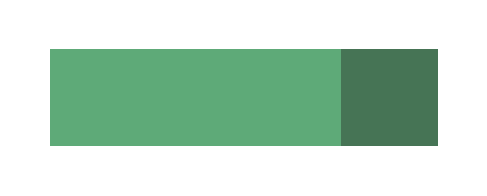

In [27]:
fig, axis = plt.subplots(figsize=(5,5))
# gs = plt.GridSpec(1,3, width_ratios=(.5,5,.5))

# axis = plt.subplot(gs[0])
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.yaxis.set_tick_params(left='off', right='off', labelsize='8')
axis.xaxis.set_tick_params(bottom='off', top='off', labelsize='8')

im = axis.imshow(atr_di_map.loc[set1,set2], interpolation = 'none', cmap=diffColors, vmin=-4.0, vmax=4.0)
axis.set_xticks([])
axis.set_yticks([])
#plt.savefig('/Users/benh/Desktop/for_figs/tip60-v-cc_di_atr.png',dpi=300)


In [25]:
## Make cluster matrices for the consensus map and well as each individual map

consensus_cluster_matrix = pd.DataFrame(index = concat_map.index, columns = range(302))

for cluster in consensus_cluster_matrix.columns:
    branch_identity = []
    deconstruct_tree(cluster,consensus_distance)
    branch_names = concat_map.iloc[branch_identity].index
    for gene in consensus_cluster_matrix.index:
        if gene in branch_names:
            consensus_cluster_matrix.loc[gene,cluster] = True
        else:
            consensus_cluster_matrix.loc[gene,cluster] = False

In [26]:
cluster_thresh_list = []
for i in np.arange(0,1.1,0.01):
    cluster_thresh_list.append(len(cluster_thresh(consensus_distance,i)))

(0.0, 60.0)

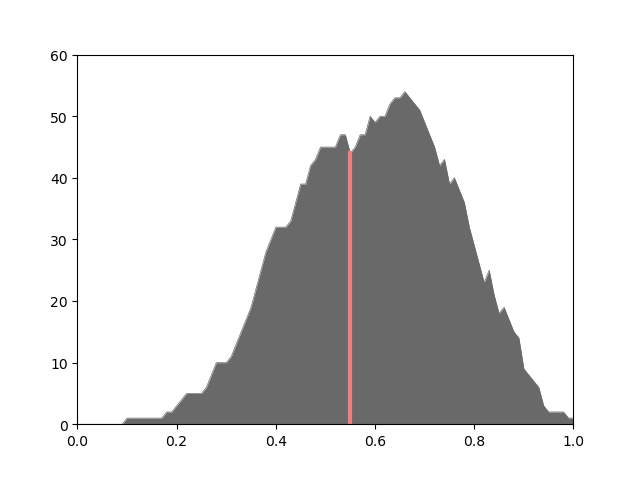

In [27]:
plt.plot(np.arange(0,1.1,0.01),cluster_thresh_list,c='dimgray')
#plt.savefig('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/gi2/plots/cluster_formation.png',dpi=300)

plt.fill_between(np.arange(0,1.1,0.01),cluster_thresh_list,color='dimgray')
plt.plot((0.55,0.55),(0,44),c='lightcoral',lw=3)
plt.xlim(0,1)
plt.ylim(0,60)
#plt.savefig('/Users/benh/Desktop/for_figs/concensus_cluster_formation.png',dpi=300)

In [29]:
tree_slice1 = cluster_thresh(consensus_distance,0.55)

In [82]:
consensus_annotations = pd.DataFrame(index = tree_slice1,columns = ['Term','Genes'])

In [31]:
i=44
for item in list(consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]==True].index):
    print(item)

IndexError: list index out of range

In [83]:
i = 0
consensus_annotations.loc[tree_slice1[i],'Term'] = 'MICOS_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = [item for item in consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index]


In [84]:
i = 1
consensus_annotations.loc[tree_slice1[i],'Term'] = 'BRCA1_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [85]:
i = 2
consensus_annotations.loc[tree_slice1[i],'Term'] = 'translation_initiation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [86]:
i = 3
consensus_annotations.loc[tree_slice1[i],'Term'] = 'TATA_binding_protein'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [87]:
i = 4
consensus_annotations.loc[tree_slice1[i],'Term'] = 'CCDC6/FBXO42'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [88]:
i = 5
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [89]:
i = 6
consensus_annotations.loc[tree_slice1[i],'Term'] = 'RFC_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [90]:
i = 7
consensus_annotations.loc[tree_slice1[i],'Term'] = 'CST_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [91]:
i = 8
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [92]:
i = 9
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [93]:
i = 10
consensus_annotations.loc[tree_slice1[i],'Term'] = 'diphthamide_biosynthesis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [94]:
i = 11
consensus_annotations.loc[tree_slice1[i],'Term'] = 'golgi_transport'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [95]:
i = 12
consensus_annotations.loc[tree_slice1[i],'Term'] = 'cohesin'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [96]:
i = 13
consensus_annotations.loc[tree_slice1[i],'Term'] = 'n6a_mehthyltransferase'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [97]:
i = 14
consensus_annotations.loc[tree_slice1[i],'Term'] = 'MRN_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [98]:
i = 15
consensus_annotations.loc[tree_slice1[i],'Term'] = 'histone_methyltransferase'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [99]:
i = 16
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [100]:
i = 17
consensus_annotations.loc[tree_slice1[i],'Term'] = 'pyrimidine_biosynthesis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [101]:
i = 18
consensus_annotations.loc[tree_slice1[i],'Term'] = 'PP2A'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [102]:
i = 19
consensus_annotations.loc[tree_slice1[i],'Term'] = 'splicing'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [103]:
i = 20
consensus_annotations.loc[tree_slice1[i],'Term'] = 'SAGA_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [104]:
i = 21
consensus_annotations.loc[tree_slice1[i],'Term'] = 'ubi_degradation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [105]:
i = 22
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [106]:
i = 23
consensus_annotations.loc[tree_slice1[i],'Term'] = 'one_carbon_metabolism'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [107]:
i = 24
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [108]:
i = 25
consensus_annotations.loc[tree_slice1[i],'Term'] = 'tRNA_wobble_modification'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [109]:
i = 26
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [110]:
i = 27
consensus_annotations.loc[tree_slice1[i],'Term'] = 'B_cell_differentiation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [111]:
i = 28
consensus_annotations.loc[tree_slice1[i],'Term'] = 'MTOR_signal_transduction'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [112]:
i = 29
consensus_annotations.loc[tree_slice1[i],'Term'] = 'TIP60'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [113]:
i = 30
consensus_annotations.loc[tree_slice1[i],'Term'] = 'neddylation'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [114]:
i = 31
consensus_annotations.loc[tree_slice1[i],'Term'] = 'G2M_checkpoint'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [115]:
i = 32
consensus_annotations.loc[tree_slice1[i],'Term'] = 'DNA_recombinase'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [116]:
i = 33
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [117]:
i = 34
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [118]:
i = 35
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [119]:
i = 36
consensus_annotations.loc[tree_slice1[i],'Term'] = 'DSB_repair'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [120]:
i = 37
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [121]:
i = 38
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [122]:
i = 39
consensus_annotations.loc[tree_slice1[i],'Term'] = 'FANC_complex'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [123]:
i = 40
consensus_annotations.loc[tree_slice1[i],'Term'] = 'mitochondrial_homeostasis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [124]:
i = 41
consensus_annotations.loc[tree_slice1[i],'Term'] = 'none'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [125]:
i = 42
consensus_annotations.loc[tree_slice1[i],'Term'] = 'glycolysis'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [126]:
i = 43
consensus_annotations.loc[tree_slice1[i],'Term'] = 'core_cell_cycle'
consensus_annotations.loc[tree_slice1[i],'Genes'] = consensus_cluster_matrix.loc[consensus_cluster_matrix[tree_slice1[i]-303]].index


In [127]:
consensus_annotations = consensus_annotations.reset_index()
count = 0
ont_list = []
ont_cluster_list = []
for item in consensus_annotations.index:
    if consensus_annotations.loc[item,'Term'] == 'none':
        ont_list.append('no_GO_'+str(count))
        count += 1
        ont_cluster_list.append(consensus_annotations.loc[item,'index']-303)
        continue
    ont_list.append(consensus_annotations.loc[item,'Term'])
    ont_cluster_list.append(consensus_annotations.loc[item,'index']-303)

consensus_annotations['Term'] = ont_list

In [128]:
consensus_annotations

index                       Term  \
0     307              MICOS_complex   
1     311              BRCA1_complex   
2     314     translation_initiation   
3     329       TATA_binding_protein   
4     330               CCDC6/FBXO42   
5     331                    no_GO_0   
6     336                RFC_complex   
7     337                CST_complex   
8     339                    no_GO_1   
9     341                    no_GO_2   
10    343   diphthamide_biosynthesis   
11    346            golgi_transport   
12    347                    cohesin   
13    349     n6a_mehthyltransferase   
14    351                MRN_complex   
15    353  histone_methyltransferase   
16    358                    no_GO_3   
17    360    pyrimidine_biosynthesis   
18    366                       PP2A   
19    369                   splicing   
20    372               SAGA_complex   
21    373            ubi_degradation   
22    375                    no_GO_4   
23    377      one_carbon_metabolism   
24    378                    no_GO_5   
25    380   tRNA_wobble_modification   
26    382                    no_GO_6   
27    386     B_cell_differentiation   
28    387   MTOR_signal_transduction   
29    388                      TIP60   
30    391                neddylation   
31    392             G2M_checkpoint   
32    394            DNA_recombinase   
33    395                    no_GO_7   
34    396                    no_GO_8   
35    397                    no_GO_9   
36    398                 DSB_repair   
37    399                   no_GO_10   
38    400                   no_GO_11   
39    401               FANC_complex   
40    402  mitochondrial_homeostasis   
41    403                   no_GO_12   
42    404                 glycolysis   
43    405            core_cell_cycle   

                                                Genes  
0                                  [C19orf70, MINOS1]  
1                                      [BARD1, BRCA1]  
2                                       [DENR, MCTS1]  
3                                      [TAF13, TAF11]  
4                                     [CCDC6, FBXO42]  
5                                  [TRNAU1AP, PRPF39]  
6                                     [CHTF18, DSCC1]  
7                                       [OBFC1, CTC1]  
8                                       [RAD17, TAF9]  
9                                    [PQBP1, TIMM17B]  
10                              [DPH1, DNAJC24, DPH2]  
11                                     [COG3, SEC22B]  
12                                     [RAD21, STAG2]  
13                          [KIAA1429, ZC3H13, CBLL1]  
14                                    [MRE11A, RAD50]  
15                                   [SETD1A, BOD1L1]  
16                                      [MCAT, BOLA3]  
17                                      [DTYMK, TYMS]  
18                                 [PPP2R2A, PPP2R1A]  
19                                     [PRMT5, RBM42]  
20                                    [ATXN7L3, ENY2]  
21                                     [UBR4, HECTD1]  
22                                     [LSM12, HBS1L]  
23                            [SHMT2, MTHFD1L, SFXN1]  
24                                    [GINS4, TOPBP1]  
25                        [KTI12, CTU2, ELP4, ALKBH8]  
26                                       [CASD1, WRN]  
27                                      [FLCN, FNIP1]  
28                                 [NRF1, MTOR, GAB2]  
29    [EP400, MEAF6, EPC2, BRD8, DMAP1, MRGBP, TRRAP]  
30           [DCUN1D1, NEDD8, UBA3, NEDD8-MDP1, CUL1]  
31                               [SRPR, WEE1, PKMYT1]  
32        [RAD51C, SFR1, RAD51B, RAD51D, SWI5, XRCC2]  
33                                   [VPS29, MAPKAP1]  
34                                    [ACTR6, KANSL1]  
35                       [MAX, SLC7A1, FBXO5, TCERG1]  
36                              [ZAR1L, PALB2, BRCA2]  
37                    [SMC3, DDX23, SNRNP70, SUPT16H]  
38                 

In [139]:
consensus_annotations_export = consensus_annotations.iloc[:,1:3]

In [140]:
consensus_annotations_export = consensus_annotations_export.set_index('Term')
consensus_annotations_export.to_excel('/Users/benh/Desktop/GI_data/misc/consensus_ontologies.xlsx')

In [78]:
## Non-normalized versions of each ont map
dmso1_ont_map = make_ont_map(ont_list,ont_cluster_list,dmso1_map,consensus_cluster_matrix)
dmso2_ont_map = make_ont_map(ont_list,ont_cluster_list,dmso2_map,consensus_cluster_matrix)
atr_ont_map = make_ont_map(ont_list,ont_cluster_list,atr_map,consensus_cluster_matrix)
etop_ont_map = make_ont_map(ont_list,ont_cluster_list,etop_map,consensus_cluster_matrix)
keto_ont_map = make_ont_map(ont_list,ont_cluster_list,keto_map,consensus_cluster_matrix)

In [ ]:
## Normalized versions of each ont map
dmso1_ont_map = make_ont_map(ont_list,ont_cluster_list,dmso1_map_norm,consensus_cluster_matrix)
dmso2_ont_map = make_ont_map(ont_list,ont_cluster_list,dmso2_map_norm,consensus_cluster_matrix)
atr_ont_map = make_ont_map(ont_list,ont_cluster_list,atr_map_norm,consensus_cluster_matrix)
etop_ont_map = make_ont_map(ont_list,ont_cluster_list,etop_map_norm,consensus_cluster_matrix)
keto_ont_map = make_ont_map(ont_list,ont_cluster_list,keto_map_norm,consensus_cluster_matrix)

In [79]:
dmso1_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso1_ont_map.xlsx')
dmso1_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso1_ont_map.xlsx',index_col=0)
dmso2_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso2_ont_map.xlsx')
dmso2_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/dmso2_ont_map.xlsx',index_col=0)
atr_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/atr_ont_map.xlsx')
atr_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/atr_ont_map.xlsx',index_col=0)
etop_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/etop_ont_map.xlsx')
etop_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/etop_ont_map.xlsx',index_col=0)
keto_ont_map.to_excel('/Users/benh/Desktop/GI_data/ont_maps/keto_ont_map.xlsx')
keto_ont_map = pd.read_excel('/Users/benh/Desktop/GI_data/ont_maps/keto_ont_map.xlsx',index_col=0)

In [80]:
## Make differential ont maps
dmso_di_ont_map = dmso2_ont_map - dmso1_ont_map
atr_di_ont_map = atr_ont_map - dmso1_ont_map
etop_di_ont_map = etop_ont_map - dmso2_ont_map
keto_di_ont_map = keto_ont_map - dmso2_ont_map

In [345]:
gimap = dmso2_clustered
diff = False

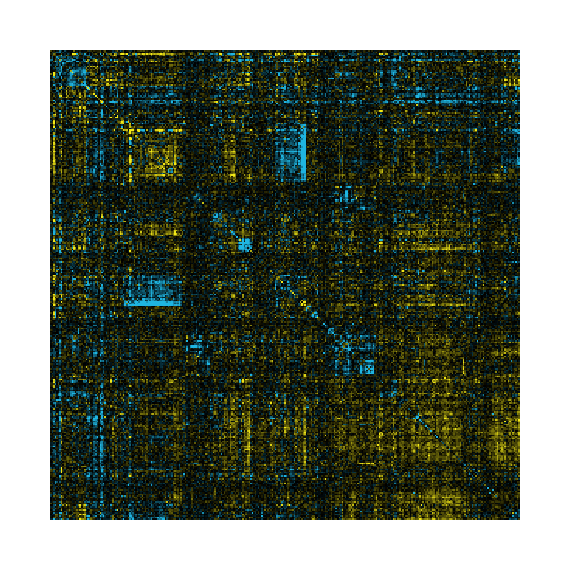

In [346]:
fig, axis = plt.subplots(figsize=(5,5))
# gs = plt.GridSpec(1,3, width_ratios=(.5,5,.5))

# axis = plt.subplot(gs[0])
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.yaxis.set_tick_params(left='off', right='off', labelsize='8')
axis.xaxis.set_tick_params(bottom='off', top='off', labelsize='8')
if diff == False:
    im = axis.imshow(gimap, interpolation = 'none', cmap=blue_yellow, vmin=-4, vmax=4)
if diff == True:
    im = axis.imshow(gimap, interpolation = 'none', cmap=diffColors, vmin=-5, vmax=5)
axis.set_xticks([])
axis.set_yticks([])

#axis.set_xlim((-50, 130))
#axis.set_ylim((130,-10))

# plt.colorbar(mappable=im, ax=plt.subplot(gs[2]), shrink=0.5)
plt.tight_layout()
plt.savefig('/Users/benh/Desktop/for_figs/dmso2_map.png',dpi=300)

In [81]:
cmap = sns.color_palette("husl",len(ont_list))
ont_color_key = dict()
for i in range(len(ont_list)):
    ont_color_key[ont_list[i]] = cmap[i]

In [82]:
## Grab map specific thersholds from "gi2_differential_analysis"notebook
dmso2_thresh = 3.403404848545315
etop_thresh = 3.0725984290302044
keto_thresh = 3.3499189170265193
dmso1_thresh = 3.516019051020592
atr_thresh = 3.1814800400738763

dmso_di_thresh = 5.586391215221745
atr_di_thresh = 5.235884266048073
etop_di_thresh = 4.683534588231303
keto_di_thresh = 4.610517297522741



In [83]:
## Make correlation matrices for each map
dmso2_corr = dmso2_map.corr('pearson')
etop_corr = etop_map.corr('pearson')
keto_corr = keto_map.corr('pearson')

dmso1_corr = dmso1_map.corr('pearson')
atr_corr = atr_map.corr('pearson')

concat_map_y = concat_sgmap = pd.concat((dmso2_norm,etop_norm,keto_norm,dmso1_norm,atr_norm),axis=0)
concat_map_corr = concat_map_y.corr('pearson')

In [84]:
dmso_di_corr = dmso2_corr - dmso1_corr
atr_di_corr = atr_corr - dmso1_corr
etop_di_corr = etop_corr - dmso2_corr
keto_di_corr = keto_corr - dmso2_corr

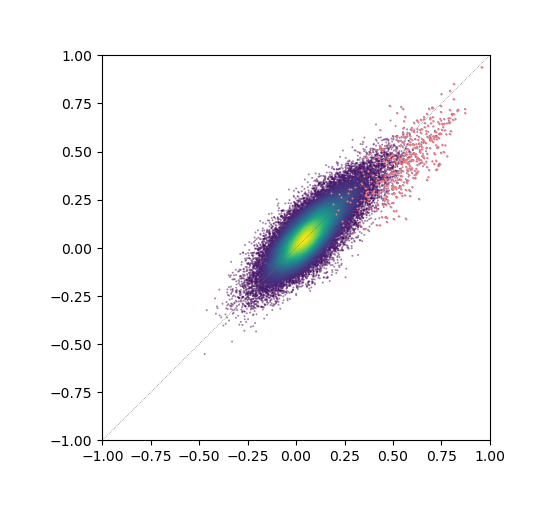

In [85]:
plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso2_corr).values,upperTriangle(dmso1_corr).values])
z = gaussian_kde(xy)(xy)
cmap = sns.color_palette("tab20_r",len(consensus_annotations.index))
plt.scatter(upperTriangle(dmso2_corr),upperTriangle(dmso1_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                upperTriangle(dmso1_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                s=2,
                color = 'lightcoral'
               )
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
#plt.savefig('/Users/benh/Desktop/for_figs/dmso2_di_corr.png',dpi=300)


In [ ]:
stats.pearsonr()

In [197]:
plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso2_corr).values,upperTriangle(atr_corr).values])
z = gaussian_kde(xy)(xy)
cmap = sns.color_palette('deep',len(consensus_annotations.index))
#cmap2 = sns.color_palette('viridis')
plt.scatter(upperTriangle(dmso2_corr),upperTriangle(atr_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                upperTriangle(atr_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                s=2,
                color = 'lightcoral'
               )
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
#plt.savefig('/Users/benh/Desktop/for_figs/atr_di_corr.png',dpi=300)
    

NameError: name 'dmso2_corr' is not defined

<Figure size 500x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso2_corr).values,upperTriangle(etop_corr).values])
z = gaussian_kde(xy)(xy)
cmap = sns.color_palette('deep',len(consensus_annotations.index))
#cmap2 = sns.color_palette('viridis')
plt.scatter(upperTriangle(dmso2_corr),upperTriangle(etop_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                upperTriangle(etop_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                s=2,
                color = 'lightcoral'
               )
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
plt.savefig('/Users/benh/Desktop/for_figs/etop_di_corr.png',dpi=300)


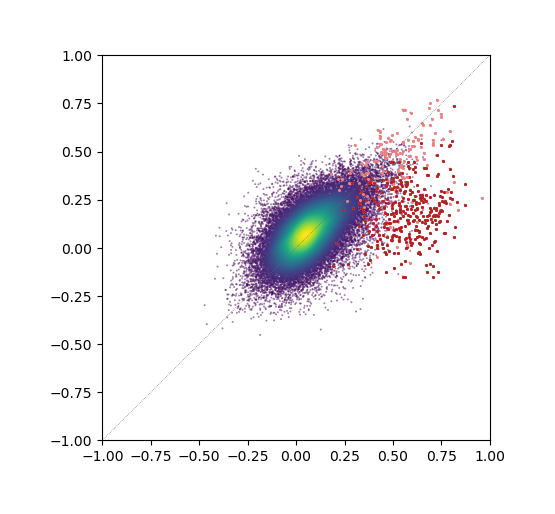

In [477]:
plt.figure(figsize=(5,5))
xy = np.vstack([upperTriangle(dmso2_corr).values,upperTriangle(keto_corr).values])
z = gaussian_kde(xy)(xy)
cmap = sns.color_palette('Reds',len(consensus_annotations.index))
#cmap2 = sns.color_palette('viridis')
plt.scatter(upperTriangle(dmso2_corr),upperTriangle(keto_corr),s=2,c=z,alpha = 0.5)
for i in range(len(consensus_annotations.index)):
    plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                upperTriangle(keto_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                s=5,
                color = 'lightcoral')
    if consensus_annotations.loc[i,'Term'] == 'mitochondrial_homeostasis':
                plt.scatter(upperTriangle(dmso2_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                            upperTriangle(keto_corr.loc[consensus_annotations.loc[i,'Genes'],consensus_annotations.loc[i,'Genes']]),
                            s=5,
                            color = 'firebrick')
plt.xlim(-1,1)
plt.ylim(-1,1)
#plt.plot((-1,1),(0,0),color='black')
#plt.plot((0,0),(-1,1),color='black')
plt.plot((-1,1),(-1,1),':',color='dimgray')
plt.savefig('/Users/benh/Desktop/for_figs/keto_di_corr.png',dpi=300)


In [ ]:
di_corr_matrix =pd.DataFrame(index = upperTriangle(dmso1_map).index)
di_corr_matrix['dmso'] = upperTriangle(dmso_di_corr).values
di_corr_matrix['atr'] = upperTriangle(atr_di_corr).values
di_corr_matrix['etop'] = upperTriangle(etop_di_corr).values
di_corr_matrix['keto'] = upperTriangle(keto_di_corr).values

In [ ]:
dmso_di_ont_corr = []
atr_di_ont_corr = []
etop_di_ont_corr = []
keto_di_ont_corr = []

di_ont_matrix = pd.DataFrame(index = consensus_annotations['Term'])
for i in range(len(di_ont_matrix.index)):
    gl = consensus_annotations.loc[i,'Genes']
    dmso_di_ont_corr.append(np.median(upperTriangle(dmso_di_corr.loc[gl,gl])))
    atr_di_ont_corr.append(np.median(upperTriangle(atr_di_corr.loc[gl,gl])))
    etop_di_ont_corr.append(np.median(upperTriangle(etop_di_corr.loc[gl,gl])))
    keto_di_ont_corr.append(np.median(upperTriangle(keto_di_corr.loc[gl,gl])))
di_ont_matrix['dmso'] = dmso_di_ont_corr
di_ont_matrix['atr'] = atr_di_ont_corr
di_ont_matrix['etop'] = etop_di_ont_corr
di_ont_matrix['keto'] = keto_di_ont_corr

In [ ]:
joypy.joyplot(di_corr_matrix,color = ['dimgray','lightcoral','mediumturquoise','forestgreen'])
joypy.joyplot(di_ont_matrix,color = ['dimgray','lightcoral','mediumturquoise','forestgreen'])
plt.xlim(-1,1)

In [ ]:
fig, axis = plt.subplots(figsize=(5,5))
# gs = plt.GridSpec(1,3, width_ratios=(.5,5,.5))

# axis = plt.subplot(gs[0])
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['left'].set_visible(False)
axis.spines['bottom'].set_visible(False)
axis.yaxis.set_tick_params(left='off', right='off', labelsize='8')
axis.xaxis.set_tick_params(bottom='off', top='off', labelsize='8')
if diff == False:
    im = axis.imshow(gimap.loc[set2,set1], interpolation = 'none', cmap=blue_yellow, vmin=-4, vmax=4)
if diff == True:
    im = axis.imshow(gimap.loc[set2,set1], interpolation = 'none', cmap=diffColors, vmin=-4, vmax=4)
axis.set_xticks([])
axis.set_yticks([])

#axis.set_xlim((-50, 130))
#axis.set_ylim((130,-10))

# plt.colorbar(mappable=im, ax=plt.subplot(gs[2]), shrink=0.5)
plt.tight_layout()
plt.savefig('/Users/benh/Desktop/for_figs/pp2a-v-wobble_dmso2.png',dpi=200)

In [160]:
consensus_annotations

index                       Term  \
0     307              MICOS_complex   
1     311              BRCA1_complex   
2     314     translation_initiation   
3     329       TATA_binding_protein   
4     330               CCDC6/FBXO42   
5     331                     novel0   
6     336                RFC_complex   
7     337                CST_complex   
8     339                     novel1   
9     341                     novel2   
10    343   diphthamide_biosynthesis   
11    346            golgi_transport   
12    347                    cohesin   
13    349     n6a_mehthyltransferase   
14    351                MRN_complex   
15    353  histone_methyltransferase   
16    358                     novel3   
17    360    pyrimidine_biosynthesis   
18    366                       PP2A   
19    369                   splicing   
20    372               SAGA_complex   
21    373            ubi_degradation   
22    375                     novel4   
23    377      one_carbon_metabolism   
24    378                     novel5   
25    380   tRNA_wobble_modification   
26    382                     novel6   
27    386     B_cell_differentiation   
28    387   MTOR_signal_transduction   
29    388                      TIP60   
30    391                neddylation   
31    392             G2M_checkpoint   
32    394            DNA_recombinase   
33    395                     novel7   
34    396                     novel8   
35    397                     novel9   
36    398                 DSB_repair   
37    399                    novel10   
38    400                    novel11   
39    401               FANC_complex   
40    402  mitochondrial_homeostasis   
41    403                    novel12   
42    404                 glycolysis   
43    405            core_cell_cycle   

                                                Genes  
0                                  [C19orf70, MINOS1]  
1                                      [BARD1, BRCA1]  
2                                       [DENR, MCTS1]  
3                                      [TAF13, TAF11]  
4                                     [CCDC6, FBXO42]  
5                                  [TRNAU1AP, PRPF39]  
6                                     [CHTF18, DSCC1]  
7                                       [OBFC1, CTC1]  
8                                       [RAD17, TAF9]  
9                                    [PQBP1, TIMM17B]  
10                              [DPH1, DNAJC24, DPH2]  
11                                     [COG3, SEC22B]  
12                                     [RAD21, STAG2]  
13                          [KIAA1429, ZC3H13, CBLL1]  
14                                    [MRE11A, RAD50]  
15                                   [SETD1A, BOD1L1]  
16                                      [MCAT, BOLA3]  
17                                      [DTYMK, TYMS]  
18                                 [PPP2R2A, PPP2R1A]  
19                                     [PRMT5, RBM42]  
20                                    [ATXN7L3, ENY2]  
21                                     [UBR4, HECTD1]  
22                                     [LSM12, HBS1L]  
23                            [SHMT2, MTHFD1L, SFXN1]  
24                                    [GINS4, TOPBP1]  
25                        [KTI12, CTU2, ELP4, ALKBH8]  
26                                       [CASD1, WRN]  
27                                      [FLCN, FNIP1]  
28                                 [NRF1, MTOR, GAB2]  
29    [EP400, MEAF6, EPC2, BRD8, DMAP1, MRGBP, TRRAP]  
30           [DCUN1D1, NEDD8, UBA3, NEDD8-MDP1, CUL1]  
31                               [SRPR, WEE1, PKMYT1]  
32        [RAD51C, SFR1, RAD51B, RAD51D, SWI5, XRCC2]  
33                                   [VPS29, MAPKAP1]  
34                                    [ACTR6, KANSL1]  
35                       [MAX, SLC7A1, FBXO5, TCERG1]  
36                              [ZAR1L, PALB2, BRCA2]  
37                    [SMC3, DDX23, SNRNP70, SUPT16H]  
38                 

In [86]:
cmap = sns.color_palette("husl",len(consensus_annotations['Term']))

ont_dict = dict()
ont_color_key = dict()

for i,ont in enumerate(consensus_annotations['Term']):
    ont_dict[ont] = 1
    ont_color_key[ont] = cmap[i]
    
#for ont in consensus_annotations:


In [87]:
circos = pycirclize.Circos(ont_dict, space=2)
for sector in circos.sectors:
    track = sector.add_track((95, 100))
    track.axis(fc='dimgray')
circos.sectors[0].name
#fig = circos.plotfig()

'MICOS_complex'

In [98]:
def gimap_circos(gimap, ont_thresh, diffbool, text_yn):
    circos = pycirclize.Circos(ont_dict, space=2)
    for sector in circos.sectors:
        track = sector.add_track((90, 100))
        track.axis(fc='dimgray')
        #track.xticks_by_interval(1,label_orientation="vertical")
        #sector.text(sector.name, r=105, size=10,facing = "outside")
    for i in range(len(consensus_annotations['Term'])):
        t1 = consensus_annotations.loc[i,'Term']
        gl1= consensus_annotations.loc[i,'Genes']
        for j in range(i+1,len(consensus_annotations['Term'])):
            t2 = consensus_annotations.loc[j,'Term']
            gl2= consensus_annotations.loc[j,'Genes']
            if gimap.loc[gl1,gl2].values.mean() > ont_thresh:
                if diffbool == False:
                    circos.link((t1, 0, 1), (t2, 1, 0),color='gold')
                if diffbool == True:
                    circos.link((t1, 0, 1), (t2, 1, 0),color='#b897e3')
                circos.tracks[i].axis(fc = ont_color_key[t1])
                circos.tracks[j].axis(fc = ont_color_key[t2])
                if text_yn == True:
                    circos.sectors[i].text(circos.sectors[i].name,r=105,size=8)
                    circos.sectors[j].text(circos.sectors[j].name,r=105,size=8)
            if gimap.loc[gl1,gl2].values.mean() < -ont_thresh:
                if diffbool == False:
                    circos.link((t1, 0, 1), (t2, 1, 0),color='mediumturquoise')
                if diffbool == True:
                    circos.link((t1, 0, 1), (t2, 1, 0),color='#7fb45c') 
                circos.tracks[i].axis(fc = ont_color_key[t1])
                circos.tracks[j].axis(fc = ont_color_key[t2])
                if text_yn == True:
                    circos.sectors[i].text(circos.sectors[i].name,r=105,size=8)
                    circos.sectors[j].text(circos.sectors[j].name,r=105,size=8)
    fig = circos.plotfig()

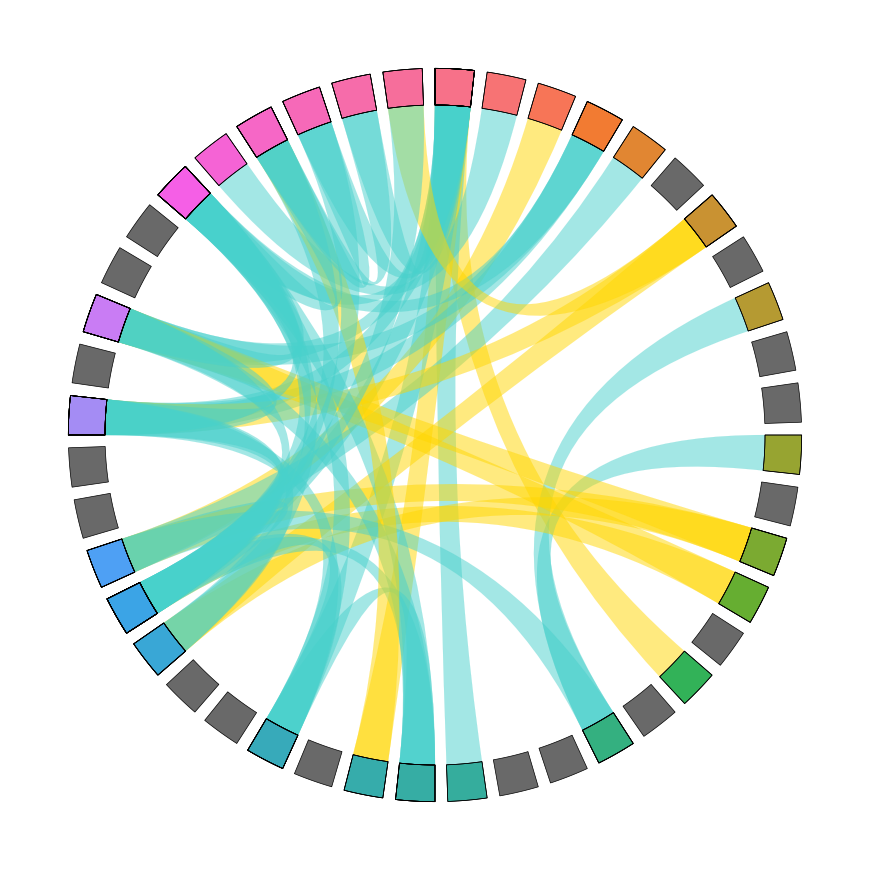

In [104]:

gimap_circos(atr_map,atr_thresh,False, False)
plt.savefig('/Users/benh/Desktop/for_figs/atr_circos.png',dpi=300)

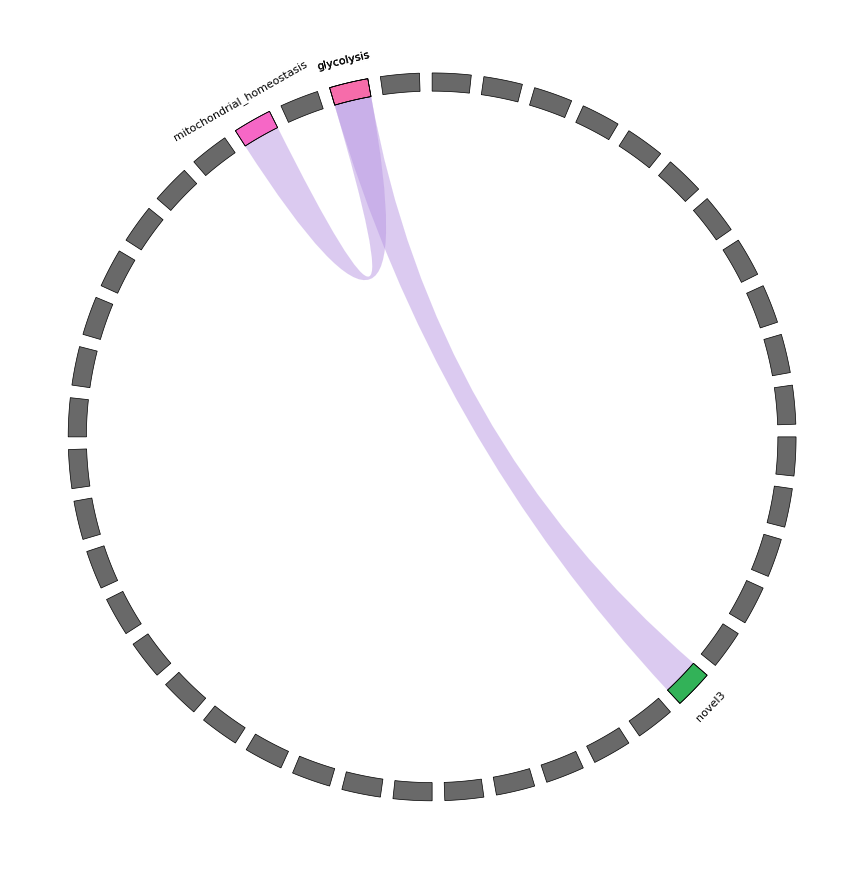

In [97]:
gimap_circos(keto_di_map,keto_di_thresh*0.8,True,True)
#plt.savefig('/Users/benh/Desktop/for_figs/atr_di_circos.png',dpi=300)

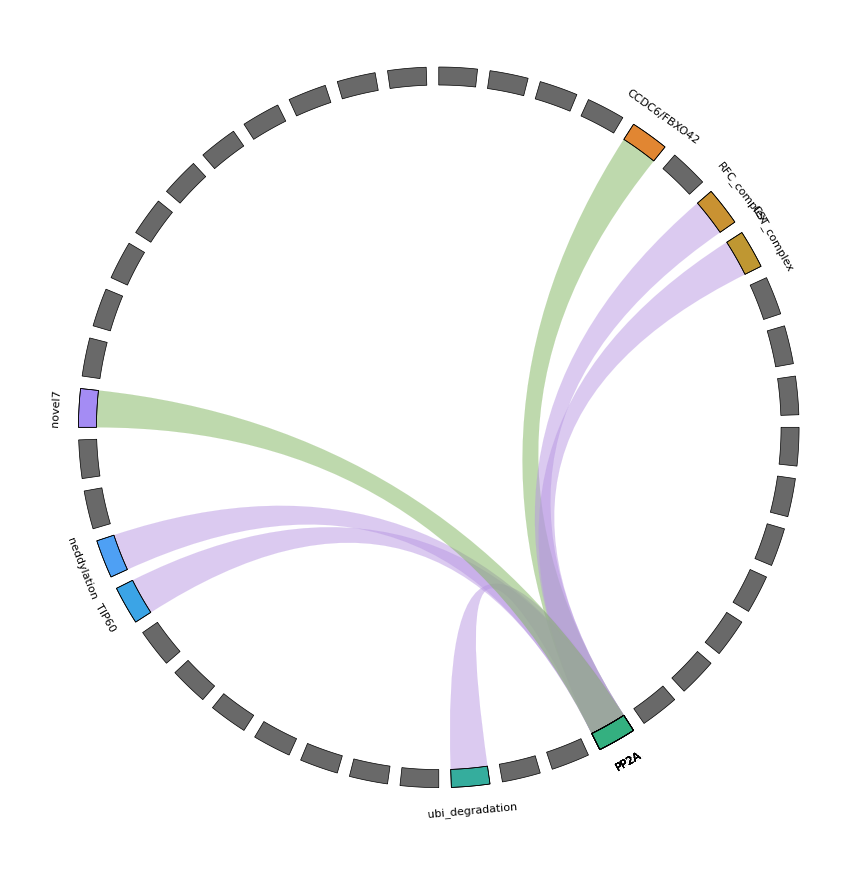

In [322]:
gimap_circos(etop_di_map,4.15,True)
#plt.savefig('/Users/benh/Desktop/for_figs/etop_di_circos.png',dpi=300)

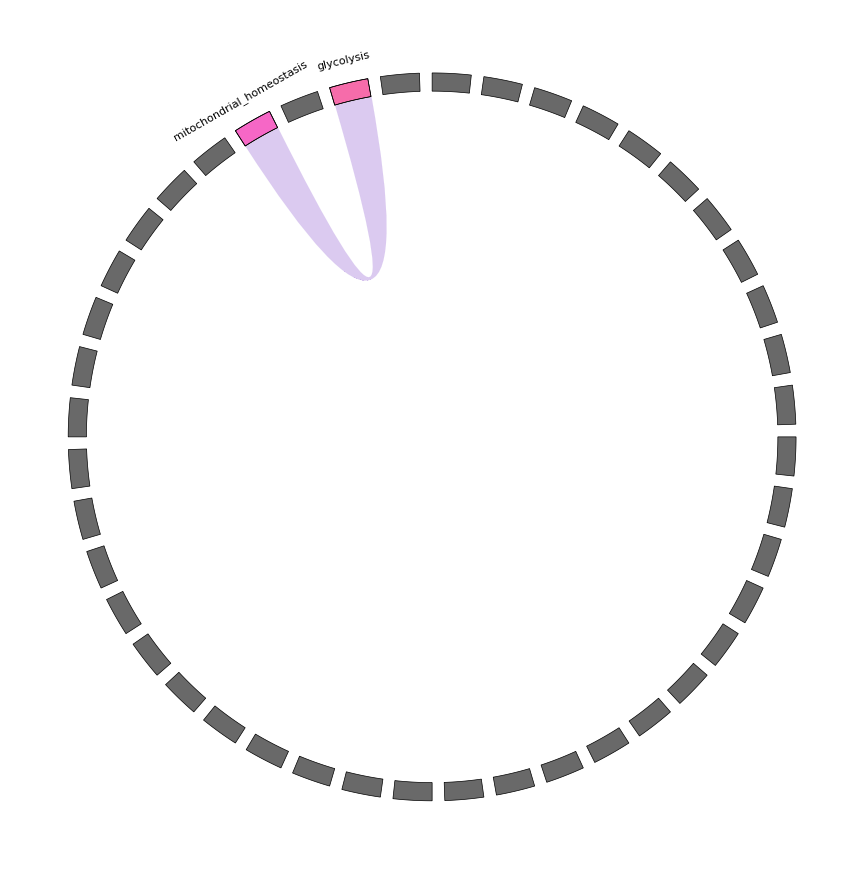

In [323]:
gimap_circos(keto_di_map,4.15,True)
#plt.savefig('/Users/benh/Desktop/for_figs/keto_di_circos.png',dpi=300)

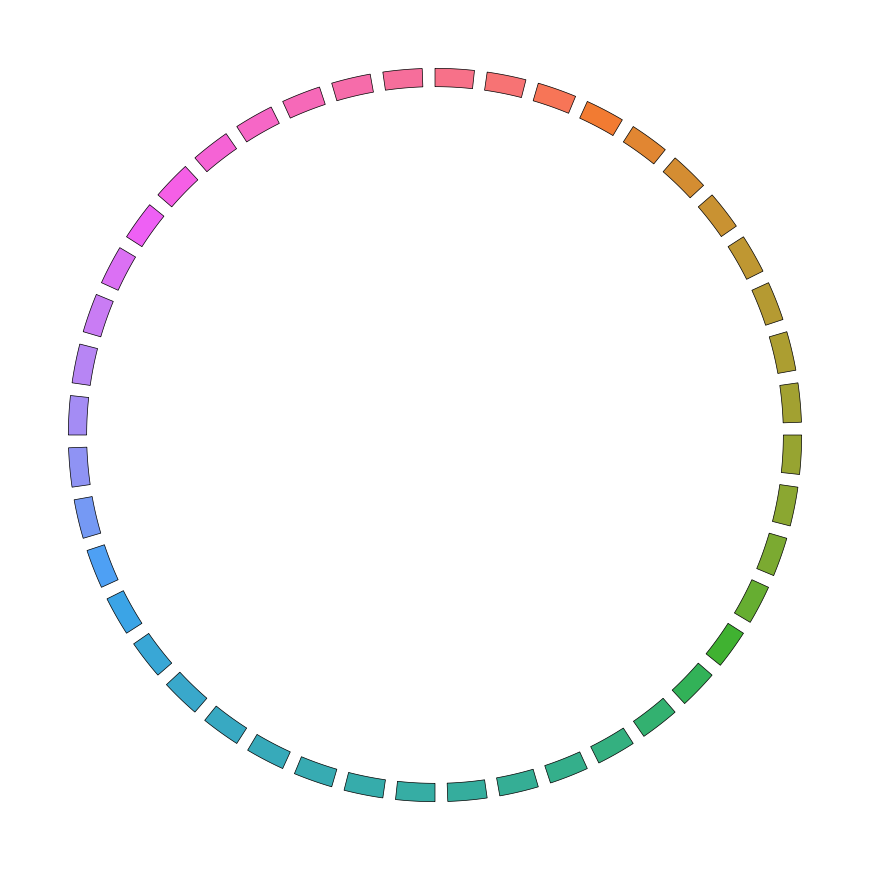

In [315]:
circos = pycirclize.Circos(ont_dict, space=2)
for sector in circos.sectors:
    track = sector.add_track((95, 100))
    track.axis(fc=ont_color_key[sector.name])
fig = circos.plotfig()
plt.savefig('/Users/benh/Desktop/for_figs/ont_circos.png',dpi=300)

In [218]:
def gimap_di_circos(dgimap, egimap, gimap, ont_thresh, text_yn):
    circos = pycirclize.Circos(ont_dict, space=2)
    for sector in circos.sectors:
        track = sector.add_track((90, 100))
        track.axis(fc='dimgray')
    for i in range(len(consensus_annotations['Term'])):
        t1 = consensus_annotations.loc[i,'Term']
        gl1= consensus_annotations.loc[i,'Genes']
        for j in range(i+1,len(consensus_annotations['Term'])):
            t2 = consensus_annotations.loc[j,'Term']
            gl2= consensus_annotations.loc[j,'Genes']
            if abs(dgimap.loc[gl1,gl2].values.mean()) > ont_thresh:
                if abs(egimap.loc[gl1,gl2].values.mean()) > ont_thresh:
                    if abs(gimap.loc[gl1,gl2].values.mean()) < ont_thresh:
                        circos.link((t1, 0, 1), (t2, 1, 0),color=sns.color_palette("Oranges",20,as_cmap=True)(abs(dgimap.loc[gl1,gl2].values.mean())))
                        circos.tracks[i].axis(fc = ont_color_key[t1])
                        circos.tracks[j].axis(fc = ont_color_key[t2])
                if abs(egimap.loc[gl1,gl2].values.mean()) < ont_thresh:
                    if abs(gimap.loc[gl1,gl2].values.mean()) > ont_thresh:
                        circos.link((t1, 0, 1), (t2, 1, 0),color=sns.color_palette("Greys",20,as_cmap=True)(abs(dgimap.loc[gl1,gl2].values.mean())))
                        circos.tracks[i].axis(fc = ont_color_key[t1])
                        circos.tracks[j].axis(fc = ont_color_key[t2])
                if text_yn == True:
                    circos.sectors[i].text(circos.sectors[i].name,r=105,size=8)
                    circos.sectors[j].text(circos.sectors[j].name,r=105,size=8)
            
                if text_yn == True:
                    circos.sectors[i].text(circos.sectors[i].name,r=105,size=8)
                    circos.sectors[j].text(circos.sectors[j].name,r=105,size=8)
    fig = circos.plotfig()

In [216]:
sns.color_palette('Greys',10,as_cmap=True)(5)

(0.9907727797001153, 0.9907727797001153, 0.9907727797001153, 1.0)

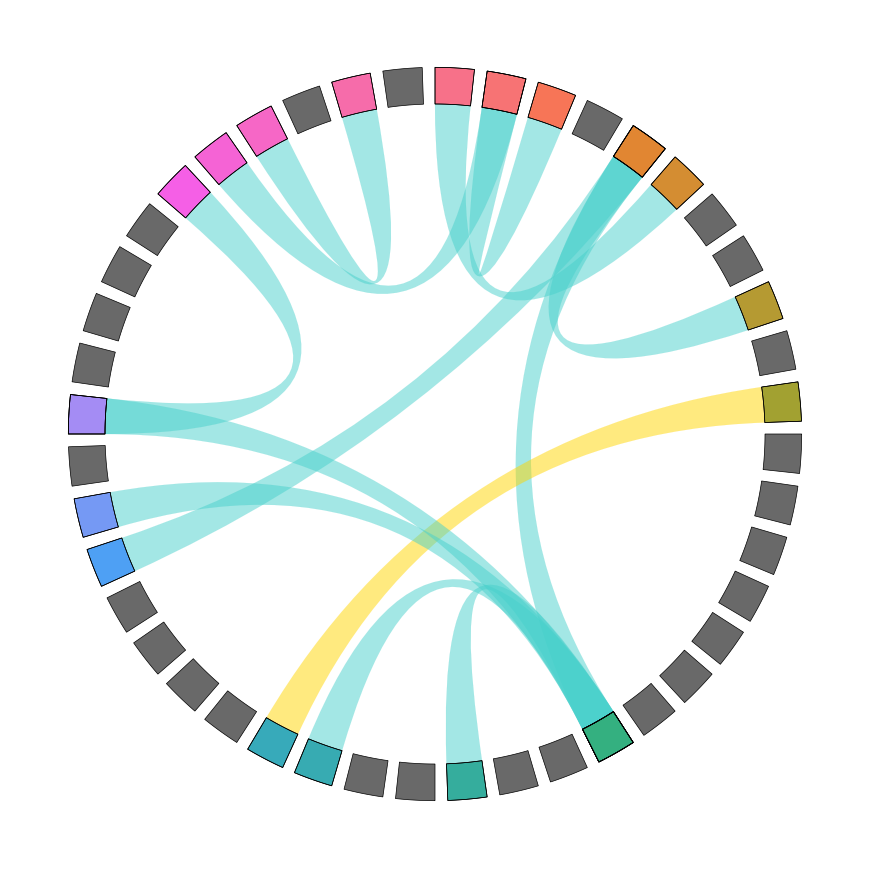

In [160]:
gimap_circos(dmso1_map,3.5,False,False)

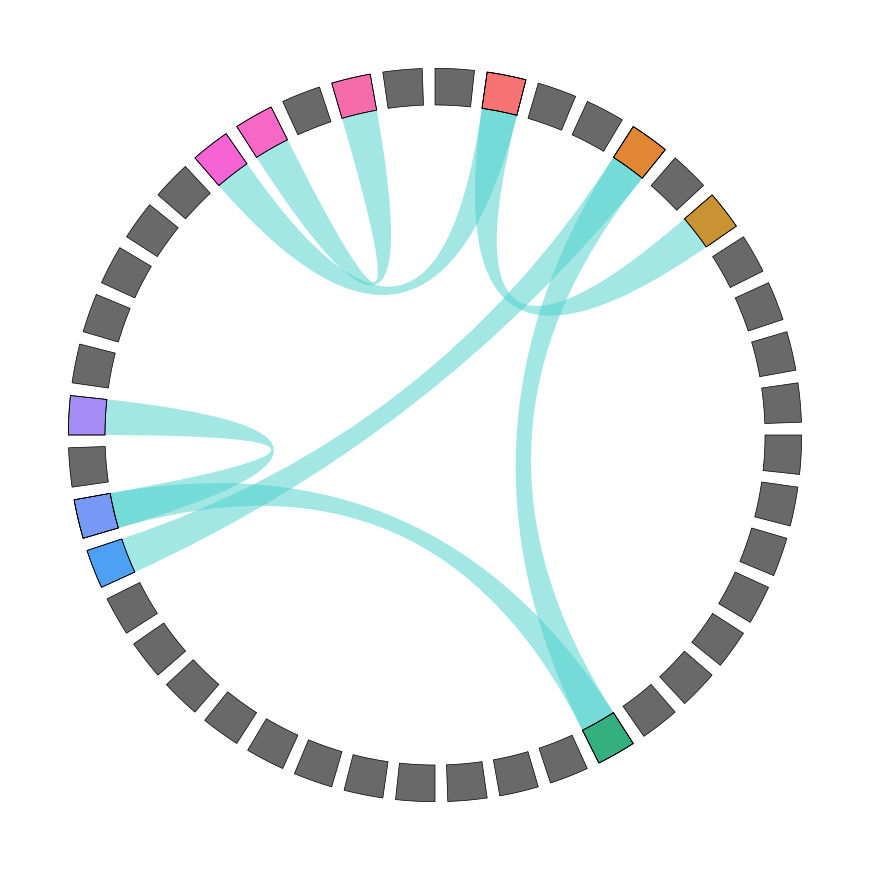

In [168]:
gimap_circos(dmso2_map,3.5,False,False)
plt.savefig('/Users/benh/Desktop/for_figs/dmso2_circos.png',dpi=300)

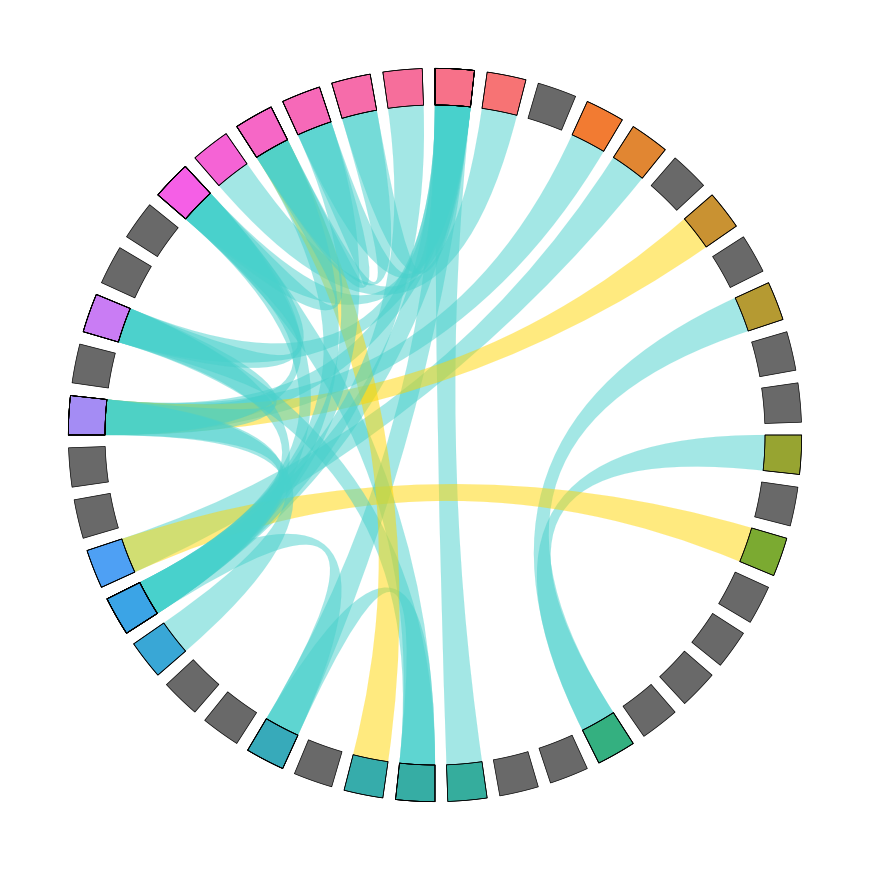

In [169]:
gimap_circos(atr_map,3.5,False,False)
plt.savefig('/Users/benh/Desktop/for_figs/atr_circos.png',dpi=300)

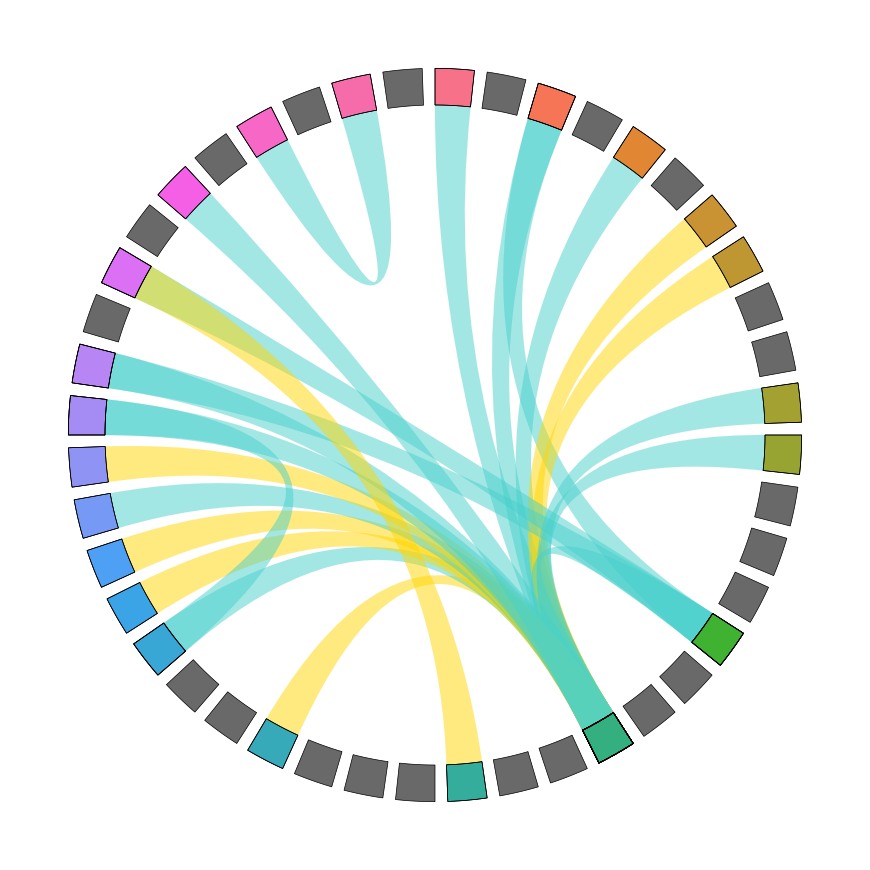

In [170]:
gimap_circos(etop_map,3.5,False,False)
plt.savefig('/Users/benh/Desktop/for_figs/etop_circos.png',dpi=300)

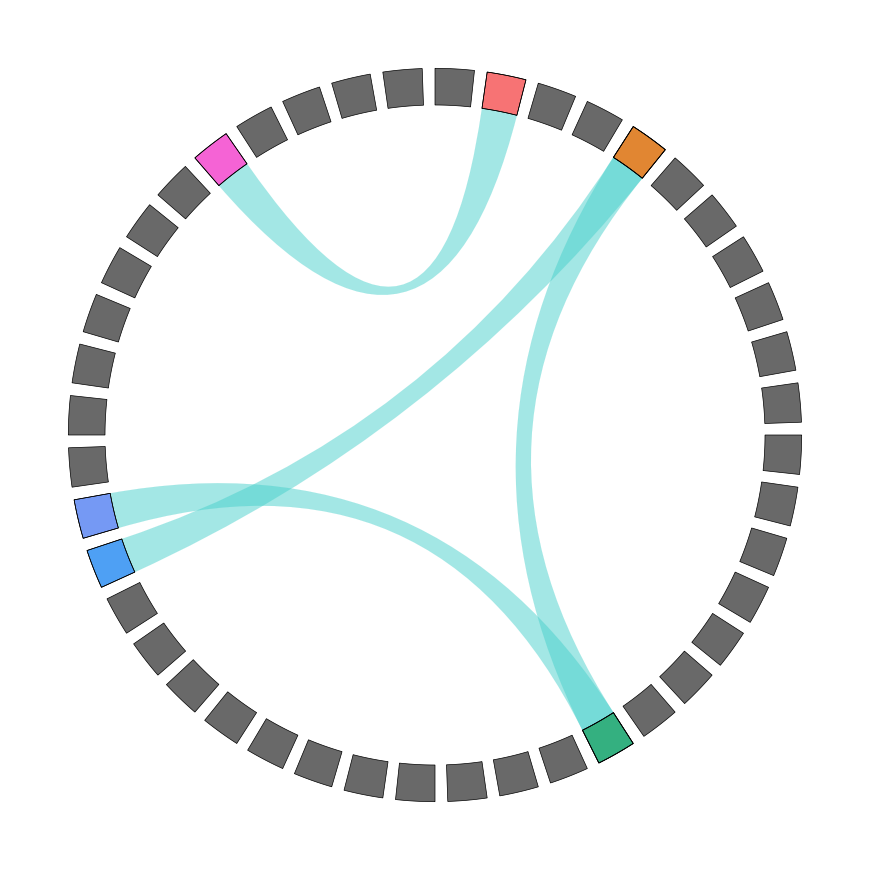

In [172]:
gimap_circos(keto_map,3.5,False,False)
plt.savefig('/Users/benh/Desktop/for_figs/keto_circos.png',dpi=300)

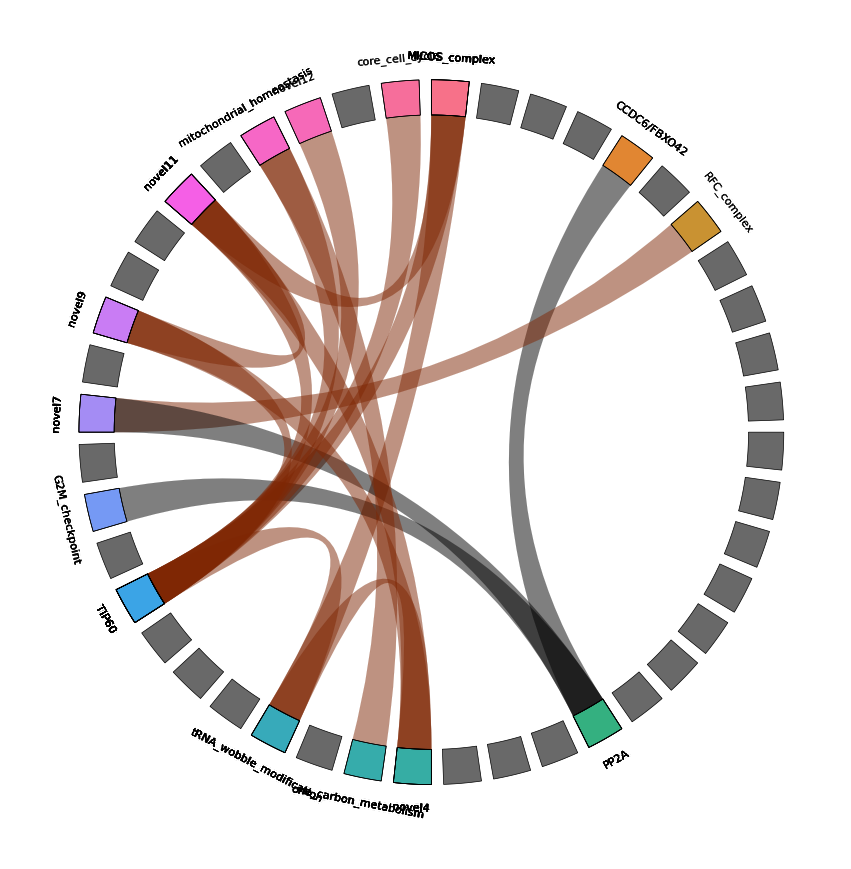

In [220]:
gimap_di_circos(atr_di_map,atr_map,dmso1_map,3.5,True)
#plt.savefig('/Users/benh/Desktop/for_figs/atr_di_circos.png',dpi=300)

In [222]:
consensus_annotations

index                       Term  \
0     307              MICOS_complex   
1     311              BRCA1_complex   
2     314     translation_initiation   
3     329       TATA_binding_protein   
4     330               CCDC6/FBXO42   
5     331                     novel0   
6     336                RFC_complex   
7     337                CST_complex   
8     339                     novel1   
9     341                     novel2   
10    343   diphthamide_biosynthesis   
11    346            golgi_transport   
12    347                    cohesin   
13    349     n6a_mehthyltransferase   
14    351                MRN_complex   
15    353  histone_methyltransferase   
16    358                     novel3   
17    360    pyrimidine_biosynthesis   
18    366                       PP2A   
19    369                   splicing   
20    372               SAGA_complex   
21    373            ubi_degradation   
22    375                     novel4   
23    377      one_carbon_metabolism   
24    378                     novel5   
25    380   tRNA_wobble_modification   
26    382                     novel6   
27    386     B_cell_differentiation   
28    387   MTOR_signal_transduction   
29    388                      TIP60   
30    391                neddylation   
31    392             G2M_checkpoint   
32    394            DNA_recombinase   
33    395                     novel7   
34    396                     novel8   
35    397                     novel9   
36    398                 DSB_repair   
37    399                    novel10   
38    400                    novel11   
39    401               FANC_complex   
40    402  mitochondrial_homeostasis   
41    403                    novel12   
42    404                 glycolysis   
43    405            core_cell_cycle   

                                                Genes  
0                                  [C19orf70, MINOS1]  
1                                      [BARD1, BRCA1]  
2                                       [DENR, MCTS1]  
3                                      [TAF13, TAF11]  
4                                     [CCDC6, FBXO42]  
5                                  [TRNAU1AP, PRPF39]  
6                                     [CHTF18, DSCC1]  
7                                       [OBFC1, CTC1]  
8                                       [RAD17, TAF9]  
9                                    [PQBP1, TIMM17B]  
10                              [DPH1, DNAJC24, DPH2]  
11                                     [COG3, SEC22B]  
12                                     [RAD21, STAG2]  
13                          [KIAA1429, ZC3H13, CBLL1]  
14                                    [MRE11A, RAD50]  
15                                   [SETD1A, BOD1L1]  
16                                      [MCAT, BOLA3]  
17                                      [DTYMK, TYMS]  
18                                 [PPP2R2A, PPP2R1A]  
19                                     [PRMT5, RBM42]  
20                                    [ATXN7L3, ENY2]  
21                                     [UBR4, HECTD1]  
22                                     [LSM12, HBS1L]  
23                            [SHMT2, MTHFD1L, SFXN1]  
24                                    [GINS4, TOPBP1]  
25                        [KTI12, CTU2, ELP4, ALKBH8]  
26                                       [CASD1, WRN]  
27                                      [FLCN, FNIP1]  
28                                 [NRF1, MTOR, GAB2]  
29    [EP400, MEAF6, EPC2, BRD8, DMAP1, MRGBP, TRRAP]  
30           [DCUN1D1, NEDD8, UBA3, NEDD8-MDP1, CUL1]  
31                               [SRPR, WEE1, PKMYT1]  
32        [RAD51C, SFR1, RAD51B, RAD51D, SWI5, XRCC2]  
33                                   [VPS29, MAPKAP1]  
34                                    [ACTR6, KANSL1]  
35                       [MAX, SLC7A1, FBXO5, TCERG1]  
36                              [ZAR1L, PALB2, BRCA2]  
37                    [SMC3, DDX23, SNRNP70, SUPT16H]  
38                 

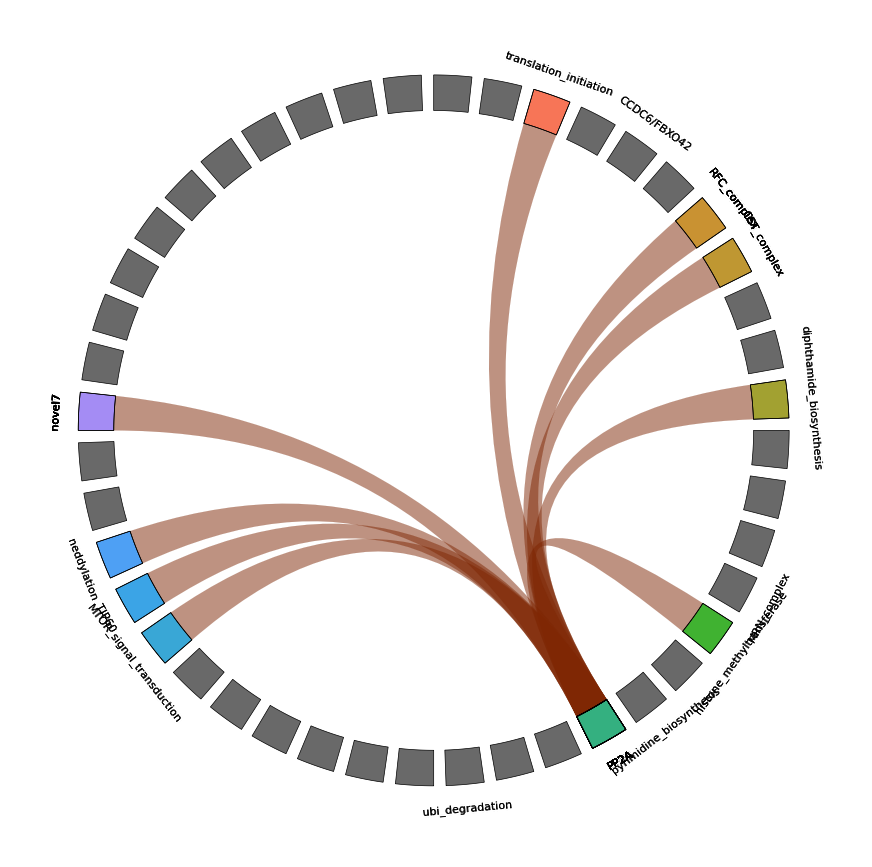

In [223]:
gimap_di_circos(etop_di_map,etop_map,dmso2_map,3.5,True)
#plt.savefig('/Users/benh/Desktop/for_figs/etop_di_circos.png',dpi=300)

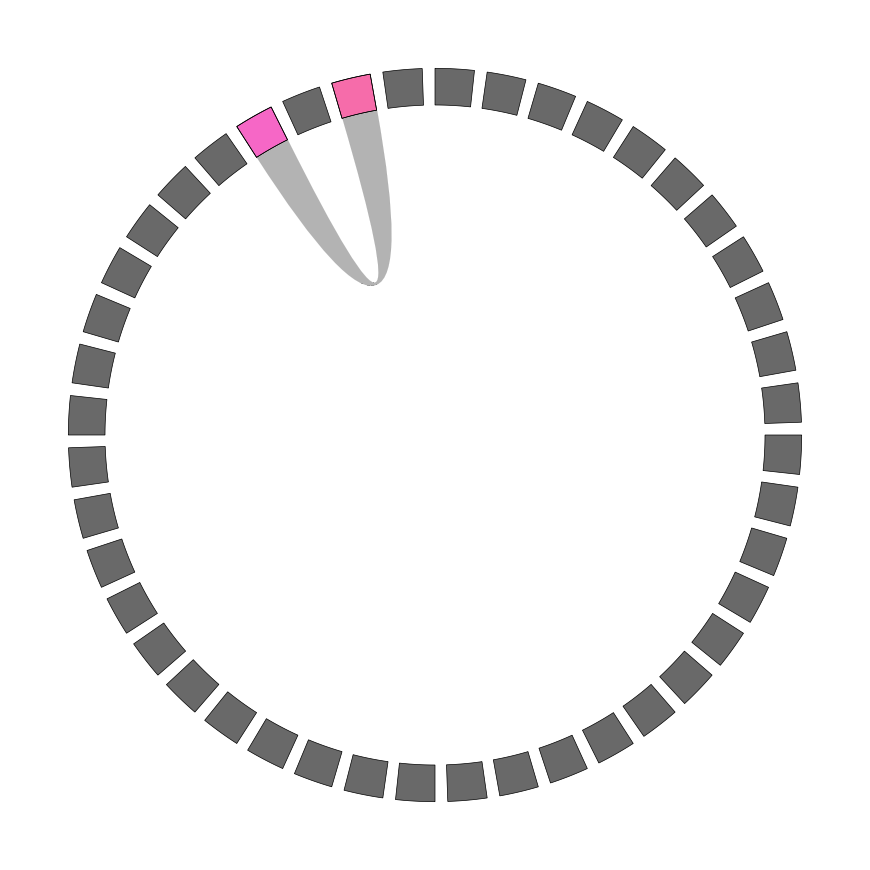

In [175]:
gimap_di_circos(keto_di_map,keto_map,dmso2_map,3.5,False)
plt.savefig('/Users/benh/Desktop/for_figs/keto_di_circos.png',dpi=300)